# Weather Prediction

In this project, we want to see if we can use machine learning to predict daily weather conditions (high/low temperature and precipitation) for a location using data from surrounding locations from preceding days.

More specifically, we are going to train a machine-learning model using daily weather data obtained from [Automated Surface Observing System (ASOS)](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/automated-surface-observing-system-asos) units for the 20-year period from 1998 through 2017.  We will use the stations within a 1000-mile radius of Roswell, Georgia, USA (my home town) and try to make predictions for the observations of the closest ASOS unit to that location.

I'm not expecting this to provide very accurate forecasts, but it serves as a simple personal project that will let me exercise the knowledge gained through recent data-science and machine-learning courses.

In [1]:
import ftplib
import gzip
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from geopy import distance

/Users/kdj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sns.set_style('whitegrid')

%matplotlib inline

## Stations

Our first goal is to get the IDs of all the stations for which we will be processing data.  We want to get a list of all the stations that are within 1000 miles of our location.

In [3]:
# Roswell, GA, USA
my_lat = 34.0232
my_lon = -84.3616

distance_threshold = 1000

date_start = 19980101
date_end = 20171231

First, read the list of all stations available in the ASOS system.

(This data comes from <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv>, but I've stored the file locally.)

In [4]:
stations = pd.read_csv('isd/isd-history.csv',
                       dtype={'USAF'         : str,
                              'WBAN'         : str,
                              'STATION NAME' : str,
                              'CTRY'         : str,
                              'STATE'        : str,
                              'ICAO'         : str,
                              'LAT'          : float,
                              'LON'          : float,
                              'ELEV(M)'      : float,
                              'BEGIN'        : int,
                              'END'          : int})

In [5]:
stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,007026,99999,WXPOD 7026,AF,NaN,NaN,0.0,0.0,7026.0,20140711,20170822
1,007070,99999,WXPOD 7070,AF,NaN,NaN,0.0,0.0,7070.0,20140923,20150926
2,008403,99999,XM10,NaN,NaN,NaN,NaN,NaN,NaN,20140101,20140412
3,008411,99999,XM20,NaN,NaN,NaN,NaN,NaN,NaN,20140102,20160217
4,008414,99999,XM18,NaN,NaN,NaN,NaN,NaN,NaN,20140101,20160217


In [6]:
stations.describe()

,LAT,LON,ELEV(M),BEGIN,END
count,28767.000000,28766.000000,28673.000000,3.005100e+04,3.005100e+04
mean,30.676749,-3.670749,339.497928,1.978650e+07,2.004861e+07
std,28.731541,87.375176,584.540215,2.365312e+05,1.899937e+05
min,-90.000000,-179.983000,-999.900000,1.901010e+07,1.905123e+07
25%,20.950000,-82.885250,20.000000,1.959010e+07,2.001101e+07
50%,38.909000,5.201000,133.000000,1.977070e+07,2.015072e+07
75%,49.658500,58.917000,424.900000,2.001113e+07,2.018042e+07
max,89.370000,179.750000,7070.000000,2.018040e+07,2.018042e+07


Let's drop any rows that have NaN for LAT or LON.

In [7]:
stations = stations.dropna(subset=['LAT', 'LON'])

We'll only look at the stations for the northern half of the western hemisphere.

In [8]:
stations = stations[(stations['LAT'] > 0.0) & (stations['LON'] < 0.0)]

Let's drop any stations for which data collection began after 1998-01-01 or ended before 2018-01-01.

In [9]:
stations = stations[stations['BEGIN'] <= date_start]
stations = stations[stations['END'] > date_end]

Now determine the distance between each station and my location.

In [10]:
def miles_from_my_location(station):
    my_loc = (my_lat, my_lon)
    station_loc = (station['LAT'], station['LON'])
    return distance.distance(my_loc, station_loc).miles

stations['DISTANCE'] = stations.apply(miles_from_my_location, axis=1)

And now only consider the stations within the 1000-mile radius.

In [11]:
stations = stations[stations['DISTANCE'] <= distance_threshold]

# Allow garbage collection of what we don't need from the original data frame.
stations = stations.copy()

Let's look at what we have.

In [12]:
stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,DISTANCE
14482,690190,13910,ABILENE DYESS AFB,US,TX,KDYS,32.433,-99.850,545.3,19431201,20180420,902.862014
15640,710630,99999,OTTAWA CDA RCS ONT,CA,NaN,NaN,45.383,-75.717,79.0,19770701,20180419,907.816765
15821,711610,99999,BROCKVILLE CLIMATE,CA,NaN,CTBO,44.633,-75.733,120.0,19930701,20180419,864.541597
15828,711680,99999,SIOUX FALLS CLIMATE,US,SD,NaN,43.733,-96.633,481.5,19941001,20180419,939.498888
15842,711830,99999,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL QU,CA,NaN,CWTQ,45.467,-73.733,32.0,19910118,20180419,969.588120


In [13]:
stations.describe()

,LAT,LON,ELEV(M),BEGIN,END,DISTANCE
count,486.000000,486.000000,486.000000,4.860000e+02,4.860000e+02,486.000000
mean,37.092963,-84.573570,163.548354,1.966858e+07,2.018042e+07,604.481595
std,6.276628,7.806057,163.556541,1.801366e+05,1.921877e+01,242.103940
min,20.522000,-101.704000,0.000000,1.935100e+07,2.018010e+07,11.541827
25%,32.361250,-90.350000,18.300000,1.946100e+07,2.018042e+07,430.809657
50%,38.347000,-83.547000,126.350000,1.973010e+07,2.018042e+07,628.350825
75%,42.232500,-78.727000,252.550000,1.978794e+07,2.018042e+07,803.484092
max,47.967000,-69.430000,1098.500000,1.997100e+07,2.018042e+07,996.596789


That gives us about 500 stations within the 1000-mile radius. If we plot the locations of these stations and our location, we can see a rough outline of the US East Coast and Gulf Coast, so our set of stations seems to be centered roughly around the southeastern US, as expected.

(-103.32504669885078, -67.8089533011492, 19.13843802991515, 49.35056197008485)

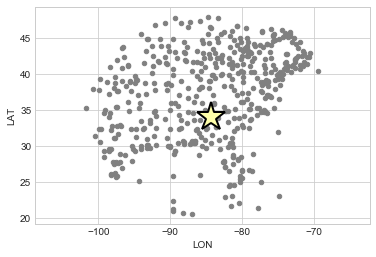

In [14]:
stations.plot.scatter(x='LON', y='LAT', c='gray')
plt.plot(my_lon, my_lat,
         '*', c='#ffffaa', markersize=30,
         markeredgewidth=2, markeredgecolor='black')
plt.axis('equal')

Most of the stations are in the US, but we also have some in Canada, Mexico, the Bahamas, and Cuba.

(The set of all country codes can be downloaded from <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/country-list.txt>.)

In [15]:
stations['CTRY'].unique()

array(['US', 'CA', 'MX', 'BF', 'CU'], dtype=object)

As a quick confidence check, let's look at the stations in Georgia.

In [16]:
stations[stations['STATE'] == 'GA']

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,DISTANCE
18030,722070,03822,SAVANNAH/HILTON HEAD INTL AIRPORT,US,GA,KSAV,32.131,-81.202,14.0,19480101,20180420,224.941914
18132,722130,13861,WAYCROSS-WARE CO. AIRPORT,US,GA,KAYS,31.250,-82.400,43.3,19421201,20180420,222.696258
18146,722137,13878,MALCOLM MC KINNON AIRPORT,US,GA,KSSI,31.152,-81.391,4.9,19730101,20180420,262.984421
18186,722160,13869,SW GEORGIA REGIONAL ARPT,US,GA,KABY,31.536,-84.194,57.9,19730101,20180420,171.671436
18196,722166,93845,VALDOSTA REGIONAL AIRPORT,US,GA,KVLD,30.783,-83.277,60.4,19480101,20180420,232.092903
18204,722170,03813,MIDDLE GEORGIA REGIONAL AIRPORT,US,GA,KMCN,32.685,-83.653,104.6,19411020,20180420,100.919468
18213,722175,13860,ROBINS AFB AIRPORT,US,GA,KWRB,32.633,-83.600,89.6,19420807,20180420,105.452655
18223,722180,03820,AUGUSTA REGIONAL AT BUSH FIELD AP,US,GA,KAGS,33.364,-81.963,40.2,19480101,20180420,145.457018
18241,722190,13874,HARTSFIELD-JACKSON ATLANTA INTL AP,US,GA,KATL,33.630,-84.442,307.9,19730101,20180420,27.491922
18331,722250,13829,LAWSON AAF AIRPORT,US,GA,KLSF,32.350,-85.000,70.7,19390501,20180420,121.096246


Those distance values look accurate (I checked using the ruler in Google Earth).

We can eyeball this list and see what the closest ASOS unit is, but we'll use Pandas to identify it.'

In [17]:
closest_station = stations.loc[stations['DISTANCE'].idxmin()]

In [18]:
closest_station

USAF                                      722270
WBAN                                       13864
STATION NAME    DOBBINS AIR RESERVE BASE AIRPORT
CTRY                                          US
STATE                                         GA
ICAO                                        KMGE
LAT                                       33.917
LON                                      -84.517
ELEV(M)                                    325.5
BEGIN                                   19460901
END                                     20180420
DISTANCE                                 11.5418
Name: 18352, dtype: object

So, we now have the 486 stations for which we will use data, and we will be trying to make predictions for the weather at [Dobbins ARB (KMGE)](https://en.wikipedia.org/wiki/Dobbins_Air_Reserve_Base).

## Fetching Weather Data for Stations

Next we need to obtain the weather information for each station for the 20-year period.

We will be using the "isd-lite" data, which is described in <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt> and <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/isd-lite-technical-document.txt>, and is available in subdirectories of <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/>.

We need some code to download these files as needed.

In [49]:
def data_file_name(station, year):
    """Return filename for the specified station for the specified year"""
    usaf = station['USAF']
    wban = station['WBAN']
    return f'{usaf}-{wban}-{year}.gz'

def ftp_server_data_path(station, year):
    """Return path to the file on the FTP server for the specified station for the specified year."""
    return f'/pub/data/noaa/isd-lite/{year}/{data_file_name(station, year)}'

def local_data_directory(year):
    """Return local directory for isd-lite data files for the specified year."""
    return f'isd/isd-lite/{year}'
    
def local_data_path(station, year):
    """Return path to local data file for the specified station for the specified year."""
    return f'{local_data_directory(year)}/{data_file_name(station, year)}'
    
def download_data_file(ftp, station, year):
    """Download the specified data file.
    
    Creates the destination directory if necessary.
    
    Returns the path to the downloaded file.
    """
    directory = local_data_directory(year)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    local_path = local_data_path(station, year)
    with open(local_path, 'wb') as f:
        cmd = f'RETR {ftp_server_data_path(station, year)}'
        ftp.retrbinary(cmd, f.write)
    return local_path

def get_downloaded_data_path(station, year):
    """Get path for the specified data file, downloading the file if necessary."""
    local_path = local_data_path(station, year)
    if not os.path.exists(local_path):
        ftp = ftplib.FTP('ftp.ncdc.noaa.gov')
        try:
            ftp.login()
            local_path = download_data_file(ftp, station, year)
            print(f'Downloaded {local_path}')
        except Exception as e:
            print(f'Unable to download {local_path}: {e}')
        finally:
            ftp.quit()
    return local_path

def get_downloaded_station_data_paths(station):
    local_paths = [get_downloaded_data_path(station, year) for year in range(1998, 2019)]
    return local_paths

In [50]:
#stations.apply(get_downloaded_station_data_paths, axis=1)

Unable to download isd/isd-lite/2004/690190-13910-2004.gz: 550 /pub/data/noaa/isd-lite/2004/690190-13910-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/690190-13910-2005.gz: 550 /pub/data/noaa/isd-lite/2005/690190-13910-2005.gz: No such file or directory
Downloaded isd/isd-lite/2006/690190-13910-2006.gz
Downloaded isd/isd-lite/2007/690190-13910-2007.gz
Downloaded isd/isd-lite/2008/690190-13910-2008.gz
Downloaded isd/isd-lite/2009/690190-13910-2009.gz
Downloaded isd/isd-lite/2010/690190-13910-2010.gz
Downloaded isd/isd-lite/2011/690190-13910-2011.gz
Downloaded isd/isd-lite/2012/690190-13910-2012.gz
Downloaded isd/isd-lite/2013/690190-13910-2013.gz
Downloaded isd/isd-lite/2014/690190-13910-2014.gz
Downloaded isd/isd-lite/2015/690190-13910-2015.gz
Downloaded isd/isd-lite/2016/690190-13910-2016.gz
Downloaded isd/isd-lite/2017/690190-13910-2017.gz
Downloaded isd/isd-lite/2018/690190-13910-2018.gz
Unable to download isd/isd-lite/1998/710630-99999-1998.gz: 550 /pub/da

Downloaded isd/isd-lite/2012/712600-99999-2012.gz
Downloaded isd/isd-lite/2013/712600-99999-2013.gz
Downloaded isd/isd-lite/2014/712600-99999-2014.gz
Downloaded isd/isd-lite/2015/712600-99999-2015.gz
Downloaded isd/isd-lite/2016/712600-99999-2016.gz
Downloaded isd/isd-lite/2017/712600-99999-2017.gz
Downloaded isd/isd-lite/2018/712600-99999-2018.gz
Downloaded isd/isd-lite/1998/712610-99999-1998.gz
Downloaded isd/isd-lite/1999/712610-99999-1999.gz
Downloaded isd/isd-lite/2000/712610-99999-2000.gz
Downloaded isd/isd-lite/2001/712610-99999-2001.gz
Downloaded isd/isd-lite/2002/712610-99999-2002.gz
Downloaded isd/isd-lite/2003/712610-99999-2003.gz
Downloaded isd/isd-lite/2004/712610-99999-2004.gz
Downloaded isd/isd-lite/2005/712610-99999-2005.gz
Downloaded isd/isd-lite/2006/712610-99999-2006.gz
Downloaded isd/isd-lite/2007/712610-99999-2007.gz
Downloaded isd/isd-lite/2008/712610-99999-2008.gz
Downloaded isd/isd-lite/2009/712610-99999-2009.gz
Downloaded isd/isd-lite/2010/712610-99999-2010.gz


Downloaded isd/isd-lite/2017/712820-99999-2017.gz
Downloaded isd/isd-lite/2018/712820-99999-2018.gz
Downloaded isd/isd-lite/1998/713680-99999-1998.gz
Downloaded isd/isd-lite/1999/713680-99999-1999.gz
Downloaded isd/isd-lite/2000/713680-99999-2000.gz
Downloaded isd/isd-lite/2001/713680-99999-2001.gz
Downloaded isd/isd-lite/2002/713680-99999-2002.gz
Downloaded isd/isd-lite/2003/713680-99999-2003.gz
Downloaded isd/isd-lite/2004/713680-99999-2004.gz
Downloaded isd/isd-lite/2005/713680-99999-2005.gz
Downloaded isd/isd-lite/2006/713680-99999-2006.gz
Downloaded isd/isd-lite/2007/713680-99999-2007.gz
Downloaded isd/isd-lite/2008/713680-99999-2008.gz
Downloaded isd/isd-lite/2009/713680-99999-2009.gz
Downloaded isd/isd-lite/2010/713680-99999-2010.gz
Downloaded isd/isd-lite/2011/713680-99999-2011.gz
Downloaded isd/isd-lite/2012/713680-99999-2012.gz
Downloaded isd/isd-lite/2013/713680-99999-2013.gz
Downloaded isd/isd-lite/2014/713680-99999-2014.gz
Downloaded isd/isd-lite/2015/713680-99999-2015.gz


Downloaded isd/isd-lite/2016/714300-99999-2016.gz
Downloaded isd/isd-lite/2017/714300-99999-2017.gz
Downloaded isd/isd-lite/2018/714300-99999-2018.gz
Downloaded isd/isd-lite/1998/714310-99999-1998.gz
Downloaded isd/isd-lite/1999/714310-99999-1999.gz
Downloaded isd/isd-lite/2000/714310-99999-2000.gz
Downloaded isd/isd-lite/2001/714310-99999-2001.gz
Downloaded isd/isd-lite/2002/714310-99999-2002.gz
Downloaded isd/isd-lite/2003/714310-99999-2003.gz
Downloaded isd/isd-lite/2004/714310-99999-2004.gz
Downloaded isd/isd-lite/2005/714310-99999-2005.gz
Downloaded isd/isd-lite/2006/714310-99999-2006.gz
Downloaded isd/isd-lite/2007/714310-99999-2007.gz
Downloaded isd/isd-lite/2008/714310-99999-2008.gz
Downloaded isd/isd-lite/2009/714310-99999-2009.gz
Downloaded isd/isd-lite/2010/714310-99999-2010.gz
Downloaded isd/isd-lite/2011/714310-99999-2011.gz
Downloaded isd/isd-lite/2012/714310-99999-2012.gz
Downloaded isd/isd-lite/2013/714310-99999-2013.gz
Downloaded isd/isd-lite/2014/714310-99999-2014.gz


Downloaded isd/isd-lite/2001/714390-99999-2001.gz
Downloaded isd/isd-lite/2002/714390-99999-2002.gz
Downloaded isd/isd-lite/2003/714390-99999-2003.gz
Downloaded isd/isd-lite/2004/714390-99999-2004.gz
Downloaded isd/isd-lite/2005/714390-99999-2005.gz
Downloaded isd/isd-lite/2006/714390-99999-2006.gz
Downloaded isd/isd-lite/2007/714390-99999-2007.gz
Downloaded isd/isd-lite/2008/714390-99999-2008.gz
Downloaded isd/isd-lite/2009/714390-99999-2009.gz
Downloaded isd/isd-lite/2010/714390-99999-2010.gz
Unable to download isd/isd-lite/2011/714390-99999-2011.gz: 550 /pub/data/noaa/isd-lite/2011/714390-99999-2011.gz: No such file or directory
Unable to download isd/isd-lite/2012/714390-99999-2012.gz: 550 /pub/data/noaa/isd-lite/2012/714390-99999-2012.gz: No such file or directory
Downloaded isd/isd-lite/2013/714390-99999-2013.gz
Downloaded isd/isd-lite/2014/714390-99999-2014.gz
Downloaded isd/isd-lite/2015/714390-99999-2015.gz
Downloaded isd/isd-lite/2016/714390-99999-2016.gz
Downloaded isd/isd-l

Unable to download isd/isd-lite/2012/715240-99999-2012.gz: 550 /pub/data/noaa/isd-lite/2012/715240-99999-2012.gz: No such file or directory
Downloaded isd/isd-lite/2013/715240-99999-2013.gz
Downloaded isd/isd-lite/2014/715240-99999-2014.gz
Downloaded isd/isd-lite/2015/715240-99999-2015.gz
Downloaded isd/isd-lite/2016/715240-99999-2016.gz
Downloaded isd/isd-lite/2017/715240-99999-2017.gz
Downloaded isd/isd-lite/2018/715240-99999-2018.gz
Downloaded isd/isd-lite/1998/715380-99999-1998.gz
Downloaded isd/isd-lite/1999/715380-99999-1999.gz
Downloaded isd/isd-lite/2000/715380-99999-2000.gz
Downloaded isd/isd-lite/2001/715380-99999-2001.gz
Downloaded isd/isd-lite/2002/715380-99999-2002.gz
Downloaded isd/isd-lite/2003/715380-99999-2003.gz
Downloaded isd/isd-lite/2004/715380-99999-2004.gz
Downloaded isd/isd-lite/2005/715380-99999-2005.gz
Downloaded isd/isd-lite/2006/715380-99999-2006.gz
Downloaded isd/isd-lite/2007/715380-99999-2007.gz
Downloaded isd/isd-lite/2008/715380-99999-2008.gz
Downloaded

Downloaded isd/isd-lite/2010/716240-99999-2010.gz
Unable to download isd/isd-lite/2011/716240-99999-2011.gz: 550 /pub/data/noaa/isd-lite/2011/716240-99999-2011.gz: No such file or directory
Unable to download isd/isd-lite/2012/716240-99999-2012.gz: 550 /pub/data/noaa/isd-lite/2012/716240-99999-2012.gz: No such file or directory
Downloaded isd/isd-lite/2013/716240-99999-2013.gz
Downloaded isd/isd-lite/2014/716240-99999-2014.gz
Downloaded isd/isd-lite/2015/716240-99999-2015.gz
Downloaded isd/isd-lite/2016/716240-99999-2016.gz
Downloaded isd/isd-lite/2017/716240-99999-2017.gz
Downloaded isd/isd-lite/2018/716240-99999-2018.gz
Downloaded isd/isd-lite/1998/716250-99999-1998.gz
Downloaded isd/isd-lite/1999/716250-99999-1999.gz
Downloaded isd/isd-lite/2000/716250-99999-2000.gz
Downloaded isd/isd-lite/2001/716250-99999-2001.gz
Downloaded isd/isd-lite/2002/716250-99999-2002.gz
Downloaded isd/isd-lite/2003/716250-99999-2003.gz
Downloaded isd/isd-lite/2004/716250-99999-2004.gz
Downloaded isd/isd-l

Downloaded isd/isd-lite/2006/716330-99999-2006.gz
Downloaded isd/isd-lite/2007/716330-99999-2007.gz
Downloaded isd/isd-lite/2008/716330-99999-2008.gz
Downloaded isd/isd-lite/2009/716330-99999-2009.gz
Downloaded isd/isd-lite/2010/716330-99999-2010.gz
Downloaded isd/isd-lite/2011/716330-99999-2011.gz
Downloaded isd/isd-lite/2012/716330-99999-2012.gz
Downloaded isd/isd-lite/2013/716330-99999-2013.gz
Downloaded isd/isd-lite/2014/716330-99999-2014.gz
Downloaded isd/isd-lite/2015/716330-99999-2015.gz
Downloaded isd/isd-lite/2016/716330-99999-2016.gz
Downloaded isd/isd-lite/2017/716330-99999-2017.gz
Downloaded isd/isd-lite/2018/716330-99999-2018.gz
Downloaded isd/isd-lite/1998/716420-99999-1998.gz
Downloaded isd/isd-lite/1999/716420-99999-1999.gz
Downloaded isd/isd-lite/2000/716420-99999-2000.gz
Downloaded isd/isd-lite/2001/716420-99999-2001.gz
Downloaded isd/isd-lite/2002/716420-99999-2002.gz
Downloaded isd/isd-lite/2003/716420-99999-2003.gz
Downloaded isd/isd-lite/2004/716420-99999-2004.gz


Downloaded isd/isd-lite/2016/717380-99999-2016.gz
Downloaded isd/isd-lite/2017/717380-99999-2017.gz
Downloaded isd/isd-lite/2018/717380-99999-2018.gz
Downloaded isd/isd-lite/1998/718200-99999-1998.gz
Downloaded isd/isd-lite/1999/718200-99999-1999.gz
Downloaded isd/isd-lite/2000/718200-99999-2000.gz
Downloaded isd/isd-lite/2001/718200-99999-2001.gz
Downloaded isd/isd-lite/2002/718200-99999-2002.gz
Downloaded isd/isd-lite/2003/718200-99999-2003.gz
Downloaded isd/isd-lite/2004/718200-99999-2004.gz
Downloaded isd/isd-lite/2005/718200-99999-2005.gz
Downloaded isd/isd-lite/2006/718200-99999-2006.gz
Downloaded isd/isd-lite/2007/718200-99999-2007.gz
Downloaded isd/isd-lite/2008/718200-99999-2008.gz
Downloaded isd/isd-lite/2009/718200-99999-2009.gz
Downloaded isd/isd-lite/2010/718200-99999-2010.gz
Downloaded isd/isd-lite/2011/718200-99999-2011.gz
Downloaded isd/isd-lite/2012/718200-99999-2012.gz
Downloaded isd/isd-lite/2013/718200-99999-2013.gz
Downloaded isd/isd-lite/2014/718200-99999-2014.gz


Downloaded isd/isd-lite/2008/722026-12826-2008.gz
Downloaded isd/isd-lite/2009/722026-12826-2009.gz
Downloaded isd/isd-lite/2010/722026-12826-2010.gz
Downloaded isd/isd-lite/2011/722026-12826-2011.gz
Downloaded isd/isd-lite/2012/722026-12826-2012.gz
Downloaded isd/isd-lite/2013/722026-12826-2013.gz
Downloaded isd/isd-lite/2014/722026-12826-2014.gz
Downloaded isd/isd-lite/2015/722026-12826-2015.gz
Downloaded isd/isd-lite/2016/722026-12826-2016.gz
Downloaded isd/isd-lite/2017/722026-12826-2017.gz
Downloaded isd/isd-lite/2018/722026-12826-2018.gz
Downloaded isd/isd-lite/1998/722030-12844-1998.gz
Downloaded isd/isd-lite/1999/722030-12844-1999.gz
Downloaded isd/isd-lite/2000/722030-12844-2000.gz
Downloaded isd/isd-lite/2001/722030-12844-2001.gz
Downloaded isd/isd-lite/2002/722030-12844-2002.gz
Downloaded isd/isd-lite/2003/722030-12844-2003.gz
Downloaded isd/isd-lite/2004/722030-12844-2004.gz
Downloaded isd/isd-lite/2005/722030-12844-2005.gz
Downloaded isd/isd-lite/2006/722030-12844-2006.gz


Downloaded isd/isd-lite/2004/722065-93837-2004.gz
Downloaded isd/isd-lite/2005/722065-93837-2005.gz
Downloaded isd/isd-lite/2006/722065-93837-2006.gz
Downloaded isd/isd-lite/2007/722065-93837-2007.gz
Downloaded isd/isd-lite/2008/722065-93837-2008.gz
Downloaded isd/isd-lite/2009/722065-93837-2009.gz
Downloaded isd/isd-lite/2010/722065-93837-2010.gz
Downloaded isd/isd-lite/2011/722065-93837-2011.gz
Downloaded isd/isd-lite/2012/722065-93837-2012.gz
Downloaded isd/isd-lite/2013/722065-93837-2013.gz
Downloaded isd/isd-lite/2014/722065-93837-2014.gz
Downloaded isd/isd-lite/2015/722065-93837-2015.gz
Downloaded isd/isd-lite/2016/722065-93837-2016.gz
Downloaded isd/isd-lite/2017/722065-93837-2017.gz
Downloaded isd/isd-lite/2018/722065-93837-2018.gz
Downloaded isd/isd-lite/1998/722066-03853-1998.gz
Downloaded isd/isd-lite/1999/722066-03853-1999.gz
Downloaded isd/isd-lite/2000/722066-03853-2000.gz
Downloaded isd/isd-lite/2001/722066-03853-2001.gz
Downloaded isd/isd-lite/2002/722066-03853-2002.gz


Downloaded isd/isd-lite/2014/722110-12842-2014.gz
Downloaded isd/isd-lite/2015/722110-12842-2015.gz
Downloaded isd/isd-lite/2016/722110-12842-2016.gz
Downloaded isd/isd-lite/2017/722110-12842-2017.gz
Downloaded isd/isd-lite/2018/722110-12842-2018.gz
Unable to download isd/isd-lite/1998/722118-99999-1998.gz: 550 /pub/data/noaa/isd-lite/1998/722118-99999-1998.gz: No such file or directory
Unable to download isd/isd-lite/1999/722118-99999-1999.gz: 550 /pub/data/noaa/isd-lite/1999/722118-99999-1999.gz: No such file or directory
Unable to download isd/isd-lite/2000/722118-99999-2000.gz: 550 /pub/data/noaa/isd-lite/2000/722118-99999-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/722118-99999-2001.gz: 550 /pub/data/noaa/isd-lite/2001/722118-99999-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/722118-99999-2002.gz: 550 /pub/data/noaa/isd-lite/2002/722118-99999-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/722118-99999-

Downloaded isd/isd-lite/2013/722160-13869-2013.gz
Downloaded isd/isd-lite/2014/722160-13869-2014.gz
Downloaded isd/isd-lite/2015/722160-13869-2015.gz
Downloaded isd/isd-lite/2016/722160-13869-2016.gz
Downloaded isd/isd-lite/2017/722160-13869-2017.gz
Downloaded isd/isd-lite/2018/722160-13869-2018.gz
Downloaded isd/isd-lite/1998/722166-93845-1998.gz
Downloaded isd/isd-lite/1999/722166-93845-1999.gz
Unable to download isd/isd-lite/2000/722166-93845-2000.gz: 550 /pub/data/noaa/isd-lite/2000/722166-93845-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/722166-93845-2001.gz: 550 /pub/data/noaa/isd-lite/2001/722166-93845-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/722166-93845-2002.gz: 550 /pub/data/noaa/isd-lite/2002/722166-93845-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/722166-93845-2003.gz: 550 /pub/data/noaa/isd-lite/2003/722166-93845-2003.gz: No such file or directory
Downloaded isd/isd-lite/2004/722166-9384

Unable to download isd/isd-lite/2001/722210-13858-2001.gz: 550 /pub/data/noaa/isd-lite/2001/722210-13858-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/722210-13858-2002.gz: 550 /pub/data/noaa/isd-lite/2002/722210-13858-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/722210-13858-2003.gz: 550 /pub/data/noaa/isd-lite/2003/722210-13858-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/722210-13858-2004.gz: 550 /pub/data/noaa/isd-lite/2004/722210-13858-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/722210-13858-2005.gz: 550 /pub/data/noaa/isd-lite/2005/722210-13858-2005.gz: No such file or directory
Downloaded isd/isd-lite/2006/722210-13858-2006.gz
Downloaded isd/isd-lite/2007/722210-13858-2007.gz
Downloaded isd/isd-lite/2008/722210-13858-2008.gz
Downloaded isd/isd-lite/2009/722210-13858-2009.gz
Downloaded isd/isd-lite/2010/722210-13858-2010.gz
Downloaded isd/isd-lite/2011/722210-13858-2011.gz


Unable to download isd/isd-lite/2001/722246-03844-2001.gz: 550 /pub/data/noaa/isd-lite/2001/722246-03844-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/722246-03844-2002.gz: 550 /pub/data/noaa/isd-lite/2002/722246-03844-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/722246-03844-2003.gz: 550 /pub/data/noaa/isd-lite/2003/722246-03844-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/722246-03844-2004.gz: 550 /pub/data/noaa/isd-lite/2004/722246-03844-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/722246-03844-2005.gz: 550 /pub/data/noaa/isd-lite/2005/722246-03844-2005.gz: No such file or directory
Downloaded isd/isd-lite/2006/722246-03844-2006.gz
Downloaded isd/isd-lite/2007/722246-03844-2007.gz
Downloaded isd/isd-lite/2008/722246-03844-2008.gz
Downloaded isd/isd-lite/2009/722246-03844-2009.gz
Downloaded isd/isd-lite/2010/722246-03844-2010.gz
Downloaded isd/isd-lite/2011/722246-03844-2011.gz


Unable to download isd/isd-lite/2001/722269-03850-2001.gz: 550 /pub/data/noaa/isd-lite/2001/722269-03850-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/722269-03850-2002.gz: 550 /pub/data/noaa/isd-lite/2002/722269-03850-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/722269-03850-2003.gz: 550 /pub/data/noaa/isd-lite/2003/722269-03850-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/722269-03850-2004.gz: 550 /pub/data/noaa/isd-lite/2004/722269-03850-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/722269-03850-2005.gz: 550 /pub/data/noaa/isd-lite/2005/722269-03850-2005.gz: No such file or directory
Downloaded isd/isd-lite/2006/722269-03850-2006.gz
Downloaded isd/isd-lite/2007/722269-03850-2007.gz
Downloaded isd/isd-lite/2008/722269-03850-2008.gz
Downloaded isd/isd-lite/2009/722269-03850-2009.gz
Downloaded isd/isd-lite/2010/722269-03850-2010.gz
Downloaded isd/isd-lite/2011/722269-03850-2011.gz


Unable to download isd/isd-lite/1999/722294-99999-1999.gz: 550 /pub/data/noaa/isd-lite/1999/722294-99999-1999.gz: No such file or directory
Unable to download isd/isd-lite/2000/722294-99999-2000.gz: 550 /pub/data/noaa/isd-lite/2000/722294-99999-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/722294-99999-2001.gz: 550 /pub/data/noaa/isd-lite/2001/722294-99999-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/722294-99999-2002.gz: 550 /pub/data/noaa/isd-lite/2002/722294-99999-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/722294-99999-2003.gz: 550 /pub/data/noaa/isd-lite/2003/722294-99999-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/722294-99999-2004.gz: 550 /pub/data/noaa/isd-lite/2004/722294-99999-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/722294-99999-2005.gz: 550 /pub/data/noaa/isd-lite/2005/722294-99999-2005.gz: No such file or directory
Unable to download i

Downloaded isd/isd-lite/2018/722336-99999-2018.gz
Downloaded isd/isd-lite/1998/722340-13865-1998.gz
Downloaded isd/isd-lite/1999/722340-13865-1999.gz
Downloaded isd/isd-lite/2000/722340-13865-2000.gz
Downloaded isd/isd-lite/2001/722340-13865-2001.gz
Downloaded isd/isd-lite/2002/722340-13865-2002.gz
Downloaded isd/isd-lite/2003/722340-13865-2003.gz
Downloaded isd/isd-lite/2004/722340-13865-2004.gz
Downloaded isd/isd-lite/2005/722340-13865-2005.gz
Downloaded isd/isd-lite/2006/722340-13865-2006.gz
Downloaded isd/isd-lite/2007/722340-13865-2007.gz
Downloaded isd/isd-lite/2008/722340-13865-2008.gz
Downloaded isd/isd-lite/2009/722340-13865-2009.gz
Downloaded isd/isd-lite/2010/722340-13865-2010.gz
Downloaded isd/isd-lite/2011/722340-13865-2011.gz
Downloaded isd/isd-lite/2012/722340-13865-2012.gz
Downloaded isd/isd-lite/2013/722340-13865-2013.gz
Downloaded isd/isd-lite/2014/722340-13865-2014.gz
Downloaded isd/isd-lite/2015/722340-13865-2015.gz
Downloaded isd/isd-lite/2016/722340-13865-2016.gz


Downloaded isd/isd-lite/2017/722404-13941-2017.gz
Downloaded isd/isd-lite/2018/722404-13941-2018.gz
Downloaded isd/isd-lite/1998/722405-13976-1998.gz
Downloaded isd/isd-lite/1999/722405-13976-1999.gz
Downloaded isd/isd-lite/2000/722405-13976-2000.gz
Downloaded isd/isd-lite/2001/722405-13976-2001.gz
Downloaded isd/isd-lite/2002/722405-13976-2002.gz
Downloaded isd/isd-lite/2003/722405-13976-2003.gz
Downloaded isd/isd-lite/2004/722405-13976-2004.gz
Downloaded isd/isd-lite/2005/722405-13976-2005.gz
Downloaded isd/isd-lite/2006/722405-13976-2006.gz
Downloaded isd/isd-lite/2007/722405-13976-2007.gz
Downloaded isd/isd-lite/2008/722405-13976-2008.gz
Downloaded isd/isd-lite/2009/722405-13976-2009.gz
Downloaded isd/isd-lite/2010/722405-13976-2010.gz
Downloaded isd/isd-lite/2011/722405-13976-2011.gz
Downloaded isd/isd-lite/2012/722405-13976-2012.gz
Downloaded isd/isd-lite/2013/722405-13976-2013.gz
Downloaded isd/isd-lite/2014/722405-13976-2014.gz
Downloaded isd/isd-lite/2015/722405-13976-2015.gz


Downloaded isd/isd-lite/2013/722448-13972-2013.gz
Downloaded isd/isd-lite/2014/722448-13972-2014.gz
Downloaded isd/isd-lite/2015/722448-13972-2015.gz
Downloaded isd/isd-lite/2016/722448-13972-2016.gz
Downloaded isd/isd-lite/2017/722448-13972-2017.gz
Downloaded isd/isd-lite/2018/722448-13972-2018.gz
Downloaded isd/isd-lite/1998/722470-03901-1998.gz
Downloaded isd/isd-lite/1999/722470-03901-1999.gz
Downloaded isd/isd-lite/2000/722470-03901-2000.gz
Downloaded isd/isd-lite/2001/722470-03901-2001.gz
Downloaded isd/isd-lite/2002/722470-03901-2002.gz
Downloaded isd/isd-lite/2003/722470-03901-2003.gz
Downloaded isd/isd-lite/2004/722470-03901-2004.gz
Downloaded isd/isd-lite/2005/722470-03901-2005.gz
Downloaded isd/isd-lite/2006/722470-03901-2006.gz
Downloaded isd/isd-lite/2007/722470-03901-2007.gz
Downloaded isd/isd-lite/2008/722470-03901-2008.gz
Downloaded isd/isd-lite/2009/722470-03901-2009.gz
Downloaded isd/isd-lite/2010/722470-03901-2010.gz
Downloaded isd/isd-lite/2011/722470-03901-2011.gz


Downloaded isd/isd-lite/2012/722505-12904-2012.gz
Downloaded isd/isd-lite/2013/722505-12904-2013.gz
Downloaded isd/isd-lite/2014/722505-12904-2014.gz
Downloaded isd/isd-lite/2015/722505-12904-2015.gz
Downloaded isd/isd-lite/2016/722505-12904-2016.gz
Downloaded isd/isd-lite/2017/722505-12904-2017.gz
Downloaded isd/isd-lite/2018/722505-12904-2018.gz
Downloaded isd/isd-lite/1998/722506-12959-1998.gz
Downloaded isd/isd-lite/1999/722506-12959-1999.gz
Downloaded isd/isd-lite/2000/722506-12959-2000.gz
Downloaded isd/isd-lite/2001/722506-12959-2001.gz
Downloaded isd/isd-lite/2002/722506-12959-2002.gz
Downloaded isd/isd-lite/2003/722506-12959-2003.gz
Downloaded isd/isd-lite/2004/722506-12959-2004.gz
Downloaded isd/isd-lite/2005/722506-12959-2005.gz
Downloaded isd/isd-lite/2006/722506-12959-2006.gz
Downloaded isd/isd-lite/2007/722506-12959-2007.gz
Downloaded isd/isd-lite/2008/722506-12959-2008.gz
Downloaded isd/isd-lite/2009/722506-12959-2009.gz
Downloaded isd/isd-lite/2010/722506-12959-2010.gz


Downloaded isd/isd-lite/2001/722533-12962-2001.gz
Downloaded isd/isd-lite/2002/722533-12962-2002.gz
Downloaded isd/isd-lite/2003/722533-12962-2003.gz
Downloaded isd/isd-lite/2004/722533-12962-2004.gz
Downloaded isd/isd-lite/2005/722533-12962-2005.gz
Downloaded isd/isd-lite/2006/722533-12962-2006.gz
Downloaded isd/isd-lite/2007/722533-12962-2007.gz
Downloaded isd/isd-lite/2008/722533-12962-2008.gz
Downloaded isd/isd-lite/2009/722533-12962-2009.gz
Downloaded isd/isd-lite/2010/722533-12962-2010.gz
Downloaded isd/isd-lite/2011/722533-12962-2011.gz
Downloaded isd/isd-lite/2012/722533-12962-2012.gz
Downloaded isd/isd-lite/2013/722533-12962-2013.gz
Downloaded isd/isd-lite/2014/722533-12962-2014.gz
Downloaded isd/isd-lite/2015/722533-12962-2015.gz
Downloaded isd/isd-lite/2016/722533-12962-2016.gz
Downloaded isd/isd-lite/2017/722533-12962-2017.gz
Downloaded isd/isd-lite/2018/722533-12962-2018.gz
Downloaded isd/isd-lite/1998/722535-12909-1998.gz
Downloaded isd/isd-lite/1999/722535-12909-1999.gz


Downloaded isd/isd-lite/2007/722570-03933-2007.gz
Downloaded isd/isd-lite/2008/722570-03933-2008.gz
Downloaded isd/isd-lite/2009/722570-03933-2009.gz
Downloaded isd/isd-lite/2010/722570-03933-2010.gz
Downloaded isd/isd-lite/2011/722570-03933-2011.gz
Downloaded isd/isd-lite/2012/722570-03933-2012.gz
Downloaded isd/isd-lite/2013/722570-03933-2013.gz
Downloaded isd/isd-lite/2014/722570-03933-2014.gz
Downloaded isd/isd-lite/2015/722570-03933-2015.gz
Downloaded isd/isd-lite/2016/722570-03933-2016.gz
Downloaded isd/isd-lite/2017/722570-03933-2017.gz
Downloaded isd/isd-lite/2018/722570-03933-2018.gz
Downloaded isd/isd-lite/1998/722576-03902-1998.gz
Downloaded isd/isd-lite/1999/722576-03902-1999.gz
Unable to download isd/isd-lite/2000/722576-03902-2000.gz: 550 /pub/data/noaa/isd-lite/2000/722576-03902-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/722576-03902-2001.gz: 550 /pub/data/noaa/isd-lite/2001/722576-03902-2001.gz: No such file or directory
Unable to download i

Downloaded isd/isd-lite/2004/722600-03969-2004.gz
Downloaded isd/isd-lite/2005/722600-03969-2005.gz
Downloaded isd/isd-lite/2006/722600-03969-2006.gz
Downloaded isd/isd-lite/2007/722600-03969-2007.gz
Downloaded isd/isd-lite/2008/722600-03969-2008.gz
Downloaded isd/isd-lite/2009/722600-03969-2009.gz
Downloaded isd/isd-lite/2010/722600-03969-2010.gz
Downloaded isd/isd-lite/2011/722600-03969-2011.gz
Downloaded isd/isd-lite/2012/722600-03969-2012.gz
Downloaded isd/isd-lite/2013/722600-03969-2013.gz
Downloaded isd/isd-lite/2014/722600-03969-2014.gz
Downloaded isd/isd-lite/2015/722600-03969-2015.gz
Downloaded isd/isd-lite/2016/722600-03969-2016.gz
Downloaded isd/isd-lite/2017/722600-03969-2017.gz
Downloaded isd/isd-lite/2018/722600-03969-2018.gz
Downloaded isd/isd-lite/1998/722630-23034-1998.gz
Downloaded isd/isd-lite/1999/722630-23034-1999.gz
Downloaded isd/isd-lite/2000/722630-23034-2000.gz
Downloaded isd/isd-lite/2001/722630-23034-2001.gz
Downloaded isd/isd-lite/2002/722630-23034-2002.gz


Unable to download isd/isd-lite/2000/723067-93726-2000.gz: 550 /pub/data/noaa/isd-lite/2000/723067-93726-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/723067-93726-2001.gz: 550 /pub/data/noaa/isd-lite/2001/723067-93726-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/723067-93726-2002.gz: 550 /pub/data/noaa/isd-lite/2002/723067-93726-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/723067-93726-2003.gz: 550 /pub/data/noaa/isd-lite/2003/723067-93726-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/723067-93726-2004.gz: 550 /pub/data/noaa/isd-lite/2004/723067-93726-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/723067-93726-2005.gz: 550 /pub/data/noaa/isd-lite/2005/723067-93726-2005.gz: No such file or directory
Downloaded isd/isd-lite/2006/723067-93726-2006.gz
Downloaded isd/isd-lite/2007/723067-93726-2007.gz
Downloaded isd/isd-lite/2008/723067-93726-2008.gz
Downloaded

Downloaded isd/isd-lite/2008/723087-93735-2008.gz
Downloaded isd/isd-lite/2009/723087-93735-2009.gz
Downloaded isd/isd-lite/2010/723087-93735-2010.gz
Downloaded isd/isd-lite/2011/723087-93735-2011.gz
Downloaded isd/isd-lite/2012/723087-93735-2012.gz
Downloaded isd/isd-lite/2013/723087-93735-2013.gz
Downloaded isd/isd-lite/2014/723087-93735-2014.gz
Downloaded isd/isd-lite/2015/723087-93735-2015.gz
Downloaded isd/isd-lite/2016/723087-93735-2016.gz
Downloaded isd/isd-lite/2017/723087-93735-2017.gz
Downloaded isd/isd-lite/2018/723087-93735-2018.gz
Downloaded isd/isd-lite/1998/723090-13754-1998.gz
Downloaded isd/isd-lite/1999/723090-13754-1999.gz
Downloaded isd/isd-lite/2000/723090-13754-2000.gz
Downloaded isd/isd-lite/2001/723090-13754-2001.gz
Downloaded isd/isd-lite/2002/723090-13754-2002.gz
Downloaded isd/isd-lite/2003/723090-13754-2003.gz
Downloaded isd/isd-lite/2004/723090-13754-2004.gz
Downloaded isd/isd-lite/2005/723090-13754-2005.gz
Downloaded isd/isd-lite/2006/723090-13754-2006.gz


Unable to download isd/isd-lite/2001/723119-13886-2001.gz: 550 /pub/data/noaa/isd-lite/2001/723119-13886-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/723119-13886-2002.gz: 550 /pub/data/noaa/isd-lite/2002/723119-13886-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/723119-13886-2003.gz: 550 /pub/data/noaa/isd-lite/2003/723119-13886-2003.gz: No such file or directory
Downloaded isd/isd-lite/2004/723119-13886-2004.gz
Downloaded isd/isd-lite/2005/723119-13886-2005.gz
Downloaded isd/isd-lite/2006/723119-13886-2006.gz
Downloaded isd/isd-lite/2007/723119-13886-2007.gz
Downloaded isd/isd-lite/2008/723119-13886-2008.gz
Downloaded isd/isd-lite/2009/723119-13886-2009.gz
Downloaded isd/isd-lite/2010/723119-13886-2010.gz
Downloaded isd/isd-lite/2011/723119-13886-2011.gz
Downloaded isd/isd-lite/2012/723119-13886-2012.gz
Downloaded isd/isd-lite/2013/723119-13886-2013.gz
Downloaded isd/isd-lite/2014/723119-13886-2014.gz
Downloaded isd/isd-lite/2015/7

Unable to download isd/isd-lite/2002/723200-93801-2002.gz: 550 /pub/data/noaa/isd-lite/2002/723200-93801-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/723200-93801-2003.gz: 550 /pub/data/noaa/isd-lite/2003/723200-93801-2003.gz: No such file or directory
Downloaded isd/isd-lite/2004/723200-93801-2004.gz
Downloaded isd/isd-lite/2005/723200-93801-2005.gz
Downloaded isd/isd-lite/2006/723200-93801-2006.gz
Downloaded isd/isd-lite/2007/723200-93801-2007.gz
Downloaded isd/isd-lite/2008/723200-93801-2008.gz
Downloaded isd/isd-lite/2009/723200-93801-2009.gz
Downloaded isd/isd-lite/2010/723200-93801-2010.gz
Downloaded isd/isd-lite/2011/723200-93801-2011.gz
Downloaded isd/isd-lite/2012/723200-93801-2012.gz
Downloaded isd/isd-lite/2013/723200-93801-2013.gz
Downloaded isd/isd-lite/2014/723200-93801-2014.gz
Downloaded isd/isd-lite/2015/723200-93801-2015.gz
Downloaded isd/isd-lite/2016/723200-93801-2016.gz
Downloaded isd/isd-lite/2017/723200-93801-2017.gz
Downloaded isd/isd-l

Downloaded isd/isd-lite/2004/723270-13897-2004.gz
Downloaded isd/isd-lite/2005/723270-13897-2005.gz
Downloaded isd/isd-lite/2006/723270-13897-2006.gz
Downloaded isd/isd-lite/2007/723270-13897-2007.gz
Downloaded isd/isd-lite/2008/723270-13897-2008.gz
Downloaded isd/isd-lite/2009/723270-13897-2009.gz
Downloaded isd/isd-lite/2010/723270-13897-2010.gz
Downloaded isd/isd-lite/2011/723270-13897-2011.gz
Downloaded isd/isd-lite/2012/723270-13897-2012.gz
Downloaded isd/isd-lite/2013/723270-13897-2013.gz
Downloaded isd/isd-lite/2014/723270-13897-2014.gz
Downloaded isd/isd-lite/2015/723270-13897-2015.gz
Downloaded isd/isd-lite/2016/723270-13897-2016.gz
Downloaded isd/isd-lite/2017/723270-13897-2017.gz
Downloaded isd/isd-lite/2018/723270-13897-2018.gz
Unable to download isd/isd-lite/1998/723274-99999-1998.gz: 550 /pub/data/noaa/isd-lite/1998/723274-99999-1998.gz: No such file or directory
Unable to download isd/isd-lite/1999/723274-99999-1999.gz: 550 /pub/data/noaa/isd-lite/1999/723274-99999-1999.

Unable to download isd/isd-lite/2002/723347-03809-2002.gz: 550 /pub/data/noaa/isd-lite/2002/723347-03809-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/723347-03809-2003.gz: 550 /pub/data/noaa/isd-lite/2003/723347-03809-2003.gz: No such file or directory
Downloaded isd/isd-lite/2004/723347-03809-2004.gz
Downloaded isd/isd-lite/2005/723347-03809-2005.gz
Downloaded isd/isd-lite/2006/723347-03809-2006.gz
Downloaded isd/isd-lite/2007/723347-03809-2007.gz
Downloaded isd/isd-lite/2008/723347-03809-2008.gz
Downloaded isd/isd-lite/2009/723347-03809-2009.gz
Downloaded isd/isd-lite/2010/723347-03809-2010.gz
Downloaded isd/isd-lite/2011/723347-03809-2011.gz
Downloaded isd/isd-lite/2012/723347-03809-2012.gz
Downloaded isd/isd-lite/2013/723347-03809-2013.gz
Downloaded isd/isd-lite/2014/723347-03809-2014.gz
Downloaded isd/isd-lite/2015/723347-03809-2015.gz
Downloaded isd/isd-lite/2016/723347-03809-2016.gz
Downloaded isd/isd-lite/2017/723347-03809-2017.gz
Downloaded isd/isd-l

Downloaded isd/isd-lite/2008/723419-93992-2008.gz
Downloaded isd/isd-lite/2009/723419-93992-2009.gz
Downloaded isd/isd-lite/2010/723419-93992-2010.gz
Downloaded isd/isd-lite/2011/723419-93992-2011.gz
Downloaded isd/isd-lite/2012/723419-93992-2012.gz
Downloaded isd/isd-lite/2013/723419-93992-2013.gz
Downloaded isd/isd-lite/2014/723419-93992-2014.gz
Downloaded isd/isd-lite/2015/723419-93992-2015.gz
Downloaded isd/isd-lite/2016/723419-93992-2016.gz
Downloaded isd/isd-lite/2017/723419-93992-2017.gz
Downloaded isd/isd-lite/2018/723419-93992-2018.gz
Unable to download isd/isd-lite/1998/723425-99999-1998.gz: 550 /pub/data/noaa/isd-lite/1998/723425-99999-1998.gz: No such file or directory
Unable to download isd/isd-lite/1999/723425-99999-1999.gz: 550 /pub/data/noaa/isd-lite/1999/723425-99999-1999.gz: No such file or directory
Unable to download isd/isd-lite/2000/723425-99999-2000.gz: 550 /pub/data/noaa/isd-lite/2000/723425-99999-2000.gz: No such file or directory
Unable to download isd/isd-lit

Downloaded isd/isd-lite/2006/723520-13902-2006.gz
Downloaded isd/isd-lite/2007/723520-13902-2007.gz
Downloaded isd/isd-lite/2008/723520-13902-2008.gz
Downloaded isd/isd-lite/2009/723520-13902-2009.gz
Downloaded isd/isd-lite/2010/723520-13902-2010.gz
Downloaded isd/isd-lite/2011/723520-13902-2011.gz
Downloaded isd/isd-lite/2012/723520-13902-2012.gz
Downloaded isd/isd-lite/2013/723520-13902-2013.gz
Downloaded isd/isd-lite/2014/723520-13902-2014.gz
Downloaded isd/isd-lite/2015/723520-13902-2015.gz
Downloaded isd/isd-lite/2016/723520-13902-2016.gz
Downloaded isd/isd-lite/2017/723520-13902-2017.gz
Downloaded isd/isd-lite/2018/723520-13902-2018.gz
Downloaded isd/isd-lite/1998/723525-93986-1998.gz
Downloaded isd/isd-lite/1999/723525-93986-1999.gz
Downloaded isd/isd-lite/2000/723525-93986-2000.gz
Downloaded isd/isd-lite/2001/723525-93986-2001.gz
Downloaded isd/isd-lite/2002/723525-93986-2002.gz
Downloaded isd/isd-lite/2003/723525-93986-2003.gz
Downloaded isd/isd-lite/2004/723525-93986-2004.gz


Downloaded isd/isd-lite/2002/723630-23047-2002.gz
Downloaded isd/isd-lite/2003/723630-23047-2003.gz
Downloaded isd/isd-lite/2004/723630-23047-2004.gz
Downloaded isd/isd-lite/2005/723630-23047-2005.gz
Downloaded isd/isd-lite/2006/723630-23047-2006.gz
Downloaded isd/isd-lite/2007/723630-23047-2007.gz
Downloaded isd/isd-lite/2008/723630-23047-2008.gz
Downloaded isd/isd-lite/2009/723630-23047-2009.gz
Downloaded isd/isd-lite/2010/723630-23047-2010.gz
Downloaded isd/isd-lite/2011/723630-23047-2011.gz
Downloaded isd/isd-lite/2012/723630-23047-2012.gz
Downloaded isd/isd-lite/2013/723630-23047-2013.gz
Downloaded isd/isd-lite/2014/723630-23047-2014.gz
Downloaded isd/isd-lite/2015/723630-23047-2015.gz
Downloaded isd/isd-lite/2016/723630-23047-2016.gz
Downloaded isd/isd-lite/2017/723630-23047-2017.gz
Downloaded isd/isd-lite/2018/723630-23047-2018.gz
Downloaded isd/isd-lite/1998/724010-13740-1998.gz
Downloaded isd/isd-lite/1999/724010-13740-1999.gz
Downloaded isd/isd-lite/2000/724010-13740-2000.gz


Downloaded isd/isd-lite/2001/724040-13721-2001.gz
Downloaded isd/isd-lite/2002/724040-13721-2002.gz
Downloaded isd/isd-lite/2003/724040-13721-2003.gz
Downloaded isd/isd-lite/2004/724040-13721-2004.gz
Downloaded isd/isd-lite/2005/724040-13721-2005.gz
Downloaded isd/isd-lite/2006/724040-13721-2006.gz
Downloaded isd/isd-lite/2007/724040-13721-2007.gz
Downloaded isd/isd-lite/2008/724040-13721-2008.gz
Downloaded isd/isd-lite/2009/724040-13721-2009.gz
Downloaded isd/isd-lite/2010/724040-13721-2010.gz
Downloaded isd/isd-lite/2011/724040-13721-2011.gz
Downloaded isd/isd-lite/2012/724040-13721-2012.gz
Downloaded isd/isd-lite/2013/724040-13721-2013.gz
Downloaded isd/isd-lite/2014/724040-13721-2014.gz
Downloaded isd/isd-lite/2015/724040-13721-2015.gz
Downloaded isd/isd-lite/2016/724040-13721-2016.gz
Downloaded isd/isd-lite/2017/724040-13721-2017.gz
Downloaded isd/isd-lite/2018/724040-13721-2018.gz
Downloaded isd/isd-lite/1998/724050-13743-1998.gz
Downloaded isd/isd-lite/1999/724050-13743-1999.gz


Unable to download isd/isd-lite/2004/724088-13707-2004.gz: 550 /pub/data/noaa/isd-lite/2004/724088-13707-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/724088-13707-2005.gz: 550 /pub/data/noaa/isd-lite/2005/724088-13707-2005.gz: No such file or directory
Downloaded isd/isd-lite/2006/724088-13707-2006.gz
Downloaded isd/isd-lite/2007/724088-13707-2007.gz
Downloaded isd/isd-lite/2008/724088-13707-2008.gz
Downloaded isd/isd-lite/2009/724088-13707-2009.gz
Downloaded isd/isd-lite/2010/724088-13707-2010.gz
Downloaded isd/isd-lite/2011/724088-13707-2011.gz
Downloaded isd/isd-lite/2012/724088-13707-2012.gz
Downloaded isd/isd-lite/2013/724088-13707-2013.gz
Downloaded isd/isd-lite/2014/724088-13707-2014.gz
Downloaded isd/isd-lite/2015/724088-13707-2015.gz
Downloaded isd/isd-lite/2016/724088-13707-2016.gz
Downloaded isd/isd-lite/2017/724088-13707-2017.gz
Downloaded isd/isd-lite/2018/724088-13707-2018.gz
Downloaded isd/isd-lite/1998/724090-14780-1998.gz
Downloaded isd/isd-l

Downloaded isd/isd-lite/2012/724110-13741-2012.gz
Downloaded isd/isd-lite/2013/724110-13741-2013.gz
Downloaded isd/isd-lite/2014/724110-13741-2014.gz
Downloaded isd/isd-lite/2015/724110-13741-2015.gz
Downloaded isd/isd-lite/2016/724110-13741-2016.gz
Downloaded isd/isd-lite/2017/724110-13741-2017.gz
Downloaded isd/isd-lite/2018/724110-13741-2018.gz
Downloaded isd/isd-lite/1998/724116-13868-1998.gz
Downloaded isd/isd-lite/1999/724116-13868-1999.gz
Unable to download isd/isd-lite/2000/724116-13868-2000.gz: 550 /pub/data/noaa/isd-lite/2000/724116-13868-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/724116-13868-2001.gz: 550 /pub/data/noaa/isd-lite/2001/724116-13868-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/724116-13868-2002.gz: 550 /pub/data/noaa/isd-lite/2002/724116-13868-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/724116-13868-2003.gz: 550 /pub/data/noaa/isd-lite/2003/724116-13868-2003.gz: No such file or 

Downloaded isd/isd-lite/2001/724220-93820-2001.gz
Downloaded isd/isd-lite/2002/724220-93820-2002.gz
Downloaded isd/isd-lite/2003/724220-93820-2003.gz
Downloaded isd/isd-lite/2004/724220-93820-2004.gz
Downloaded isd/isd-lite/2005/724220-93820-2005.gz
Downloaded isd/isd-lite/2006/724220-93820-2006.gz
Downloaded isd/isd-lite/2007/724220-93820-2007.gz
Downloaded isd/isd-lite/2008/724220-93820-2008.gz
Downloaded isd/isd-lite/2009/724220-93820-2009.gz
Downloaded isd/isd-lite/2010/724220-93820-2010.gz
Downloaded isd/isd-lite/2011/724220-93820-2011.gz
Downloaded isd/isd-lite/2012/724220-93820-2012.gz
Downloaded isd/isd-lite/2013/724220-93820-2013.gz
Downloaded isd/isd-lite/2014/724220-93820-2014.gz
Downloaded isd/isd-lite/2015/724220-93820-2015.gz
Downloaded isd/isd-lite/2016/724220-93820-2016.gz
Downloaded isd/isd-lite/2017/724220-93820-2017.gz
Downloaded isd/isd-lite/2018/724220-93820-2018.gz
Downloaded isd/isd-lite/1998/724230-93821-1998.gz
Downloaded isd/isd-lite/1999/724230-93821-1999.gz


Unable to download isd/isd-lite/2000/724275-14894-2000.gz: 550 /pub/data/noaa/isd-lite/2000/724275-14894-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/724275-14894-2001.gz: 550 /pub/data/noaa/isd-lite/2001/724275-14894-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/724275-14894-2002.gz: 550 /pub/data/noaa/isd-lite/2002/724275-14894-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/724275-14894-2003.gz: 550 /pub/data/noaa/isd-lite/2003/724275-14894-2003.gz: No such file or directory
Downloaded isd/isd-lite/2004/724275-14894-2004.gz
Downloaded isd/isd-lite/2005/724275-14894-2005.gz
Downloaded isd/isd-lite/2006/724275-14894-2006.gz
Downloaded isd/isd-lite/2007/724275-14894-2007.gz
Downloaded isd/isd-lite/2008/724275-14894-2008.gz
Downloaded isd/isd-lite/2009/724275-14894-2009.gz
Downloaded isd/isd-lite/2010/724275-14894-2010.gz
Downloaded isd/isd-lite/2011/724275-14894-2011.gz
Downloaded isd/isd-lite/2012/724275-1489

Downloaded isd/isd-lite/2010/724297-93812-2010.gz
Downloaded isd/isd-lite/2011/724297-93812-2011.gz
Downloaded isd/isd-lite/2012/724297-93812-2012.gz
Downloaded isd/isd-lite/2013/724297-93812-2013.gz
Downloaded isd/isd-lite/2014/724297-93812-2014.gz
Downloaded isd/isd-lite/2015/724297-93812-2015.gz
Downloaded isd/isd-lite/2016/724297-93812-2016.gz
Downloaded isd/isd-lite/2017/724297-93812-2017.gz
Downloaded isd/isd-lite/2018/724297-93812-2018.gz
Downloaded isd/isd-lite/1998/724320-93817-1998.gz
Downloaded isd/isd-lite/1999/724320-93817-1999.gz
Downloaded isd/isd-lite/2000/724320-93817-2000.gz
Downloaded isd/isd-lite/2001/724320-93817-2001.gz
Downloaded isd/isd-lite/2002/724320-93817-2002.gz
Downloaded isd/isd-lite/2003/724320-93817-2003.gz
Downloaded isd/isd-lite/2004/724320-93817-2004.gz
Downloaded isd/isd-lite/2005/724320-93817-2005.gz
Downloaded isd/isd-lite/2006/724320-93817-2006.gz
Downloaded isd/isd-lite/2007/724320-93817-2007.gz
Downloaded isd/isd-lite/2008/724320-93817-2008.gz


Downloaded isd/isd-lite/2006/724380-93819-2006.gz
Downloaded isd/isd-lite/2007/724380-93819-2007.gz
Downloaded isd/isd-lite/2008/724380-93819-2008.gz
Downloaded isd/isd-lite/2009/724380-93819-2009.gz
Downloaded isd/isd-lite/2010/724380-93819-2010.gz
Downloaded isd/isd-lite/2011/724380-93819-2011.gz
Downloaded isd/isd-lite/2012/724380-93819-2012.gz
Downloaded isd/isd-lite/2013/724380-93819-2013.gz
Downloaded isd/isd-lite/2014/724380-93819-2014.gz
Downloaded isd/isd-lite/2015/724380-93819-2015.gz
Downloaded isd/isd-lite/2016/724380-93819-2016.gz
Downloaded isd/isd-lite/2017/724380-93819-2017.gz
Downloaded isd/isd-lite/2018/724380-93819-2018.gz
Downloaded isd/isd-lite/1998/724386-14835-1998.gz
Downloaded isd/isd-lite/1999/724386-14835-1999.gz
Downloaded isd/isd-lite/2000/724386-14835-2000.gz
Downloaded isd/isd-lite/2001/724386-14835-2001.gz
Downloaded isd/isd-lite/2002/724386-14835-2002.gz
Downloaded isd/isd-lite/2003/724386-14835-2003.gz
Downloaded isd/isd-lite/2004/724386-14835-2004.gz


Unable to download isd/isd-lite/2003/724455-14938-2003.gz: 550 /pub/data/noaa/isd-lite/2003/724455-14938-2003.gz: No such file or directory
Downloaded isd/isd-lite/2004/724455-14938-2004.gz
Downloaded isd/isd-lite/2005/724455-14938-2005.gz
Downloaded isd/isd-lite/2006/724455-14938-2006.gz
Downloaded isd/isd-lite/2007/724455-14938-2007.gz
Downloaded isd/isd-lite/2008/724455-14938-2008.gz
Downloaded isd/isd-lite/2009/724455-14938-2009.gz
Downloaded isd/isd-lite/2010/724455-14938-2010.gz
Downloaded isd/isd-lite/2011/724455-14938-2011.gz
Downloaded isd/isd-lite/2012/724455-14938-2012.gz
Downloaded isd/isd-lite/2013/724455-14938-2013.gz
Downloaded isd/isd-lite/2014/724455-14938-2014.gz
Downloaded isd/isd-lite/2015/724455-14938-2015.gz
Downloaded isd/isd-lite/2016/724455-14938-2016.gz
Downloaded isd/isd-lite/2017/724455-14938-2017.gz
Downloaded isd/isd-lite/2018/724455-14938-2018.gz
Downloaded isd/isd-lite/1998/724457-03938-1998.gz
Downloaded isd/isd-lite/1999/724457-03938-1999.gz
Unable to 

Unable to download isd/isd-lite/2002/724490-13993-2002.gz: 550 /pub/data/noaa/isd-lite/2002/724490-13993-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/724490-13993-2003.gz: 550 /pub/data/noaa/isd-lite/2003/724490-13993-2003.gz: No such file or directory
Downloaded isd/isd-lite/2004/724490-13993-2004.gz
Downloaded isd/isd-lite/2005/724490-13993-2005.gz
Downloaded isd/isd-lite/2006/724490-13993-2006.gz
Downloaded isd/isd-lite/2007/724490-13993-2007.gz
Downloaded isd/isd-lite/2008/724490-13993-2008.gz
Downloaded isd/isd-lite/2009/724490-13993-2009.gz
Downloaded isd/isd-lite/2010/724490-13993-2010.gz
Downloaded isd/isd-lite/2011/724490-13993-2011.gz
Downloaded isd/isd-lite/2012/724490-13993-2012.gz
Downloaded isd/isd-lite/2013/724490-13993-2013.gz
Downloaded isd/isd-lite/2014/724490-13993-2014.gz
Downloaded isd/isd-lite/2015/724490-13993-2015.gz
Downloaded isd/isd-lite/2016/724490-13993-2016.gz
Downloaded isd/isd-lite/2017/724490-13993-2017.gz
Downloaded isd/isd-l

Downloaded isd/isd-lite/2012/724515-23064-2012.gz
Downloaded isd/isd-lite/2013/724515-23064-2013.gz
Downloaded isd/isd-lite/2014/724515-23064-2014.gz
Downloaded isd/isd-lite/2015/724515-23064-2015.gz
Downloaded isd/isd-lite/2016/724515-23064-2016.gz
Downloaded isd/isd-lite/2017/724515-23064-2017.gz
Downloaded isd/isd-lite/2018/724515-23064-2018.gz
Downloaded isd/isd-lite/1998/724520-03957-1998.gz
Downloaded isd/isd-lite/1999/724520-03957-1999.gz
Downloaded isd/isd-lite/2000/724520-03957-2000.gz
Downloaded isd/isd-lite/2001/724520-03957-2001.gz
Downloaded isd/isd-lite/2002/724520-03957-2002.gz
Downloaded isd/isd-lite/2003/724520-03957-2003.gz
Downloaded isd/isd-lite/2004/724520-03957-2004.gz
Downloaded isd/isd-lite/2005/724520-03957-2005.gz
Downloaded isd/isd-lite/2006/724520-03957-2006.gz
Downloaded isd/isd-lite/2007/724520-03957-2007.gz
Downloaded isd/isd-lite/2008/724520-03957-2008.gz
Downloaded isd/isd-lite/2009/724520-03957-2009.gz
Downloaded isd/isd-lite/2010/724520-03957-2010.gz


Downloaded isd/isd-lite/2004/724585-93997-2004.gz
Downloaded isd/isd-lite/2005/724585-93997-2005.gz
Downloaded isd/isd-lite/2006/724585-93997-2006.gz
Downloaded isd/isd-lite/2007/724585-93997-2007.gz
Downloaded isd/isd-lite/2008/724585-93997-2008.gz
Downloaded isd/isd-lite/2009/724585-93997-2009.gz
Downloaded isd/isd-lite/2010/724585-93997-2010.gz
Downloaded isd/isd-lite/2011/724585-93997-2011.gz
Downloaded isd/isd-lite/2012/724585-93997-2012.gz
Downloaded isd/isd-lite/2013/724585-93997-2013.gz
Downloaded isd/isd-lite/2014/724585-93997-2014.gz
Downloaded isd/isd-lite/2015/724585-93997-2015.gz
Downloaded isd/isd-lite/2016/724585-93997-2016.gz
Downloaded isd/isd-lite/2017/724585-93997-2017.gz
Downloaded isd/isd-lite/2018/724585-93997-2018.gz
Downloaded isd/isd-lite/1998/724586-03919-1998.gz
Downloaded isd/isd-lite/1999/724586-03919-1999.gz
Downloaded isd/isd-lite/2000/724586-03919-2000.gz
Downloaded isd/isd-lite/2001/724586-03919-2001.gz
Downloaded isd/isd-lite/2002/724586-03919-2002.gz


Downloaded isd/isd-lite/2008/725030-14732-2008.gz
Downloaded isd/isd-lite/2009/725030-14732-2009.gz
Downloaded isd/isd-lite/2010/725030-14732-2010.gz
Downloaded isd/isd-lite/2011/725030-14732-2011.gz
Downloaded isd/isd-lite/2012/725030-14732-2012.gz
Downloaded isd/isd-lite/2013/725030-14732-2013.gz
Downloaded isd/isd-lite/2014/725030-14732-2014.gz
Downloaded isd/isd-lite/2015/725030-14732-2015.gz
Downloaded isd/isd-lite/2016/725030-14732-2016.gz
Downloaded isd/isd-lite/2017/725030-14732-2017.gz
Downloaded isd/isd-lite/2018/725030-14732-2018.gz
Downloaded isd/isd-lite/1998/725036-14757-1998.gz
Downloaded isd/isd-lite/1999/725036-14757-1999.gz
Unable to download isd/isd-lite/2000/725036-14757-2000.gz: 550 /pub/data/noaa/isd-lite/2000/725036-14757-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/725036-14757-2001.gz: 550 /pub/data/noaa/isd-lite/2001/725036-14757-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/725036-14757-2002.gz: 550 /pub/da

Downloaded isd/isd-lite/2014/725046-14707-2014.gz
Downloaded isd/isd-lite/2015/725046-14707-2015.gz
Downloaded isd/isd-lite/2016/725046-14707-2016.gz
Downloaded isd/isd-lite/2017/725046-14707-2017.gz
Downloaded isd/isd-lite/2018/725046-14707-2018.gz
Downloaded isd/isd-lite/1998/725058-94793-1998.gz
Downloaded isd/isd-lite/1999/725058-94793-1999.gz
Unable to download isd/isd-lite/2000/725058-94793-2000.gz: 550 /pub/data/noaa/isd-lite/2000/725058-94793-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/725058-94793-2001.gz: 550 /pub/data/noaa/isd-lite/2001/725058-94793-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/725058-94793-2002.gz: 550 /pub/data/noaa/isd-lite/2002/725058-94793-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/725058-94793-2003.gz: 550 /pub/data/noaa/isd-lite/2003/725058-94793-2003.gz: No such file or directory
Downloaded isd/isd-lite/2004/725058-94793-2004.gz
Downloaded isd/isd-lite/2005/725058-9479

Downloaded isd/isd-lite/2004/725103-14712-2004.gz
Downloaded isd/isd-lite/2005/725103-14712-2005.gz
Downloaded isd/isd-lite/2006/725103-14712-2006.gz
Downloaded isd/isd-lite/2007/725103-14712-2007.gz
Downloaded isd/isd-lite/2008/725103-14712-2008.gz
Downloaded isd/isd-lite/2009/725103-14712-2009.gz
Downloaded isd/isd-lite/2010/725103-14712-2010.gz
Downloaded isd/isd-lite/2011/725103-14712-2011.gz
Downloaded isd/isd-lite/2012/725103-14712-2012.gz
Downloaded isd/isd-lite/2013/725103-14712-2013.gz
Downloaded isd/isd-lite/2014/725103-14712-2014.gz
Downloaded isd/isd-lite/2015/725103-14712-2015.gz
Downloaded isd/isd-lite/2016/725103-14712-2016.gz
Downloaded isd/isd-lite/2017/725103-14712-2017.gz
Downloaded isd/isd-lite/2018/725103-14712-2018.gz
Unable to download isd/isd-lite/1998/725105-14770-1998.gz: 550 /pub/data/noaa/isd-lite/1998/725105-14770-1998.gz: No such file or directory
Downloaded isd/isd-lite/1999/725105-14770-1999.gz
Unable to download isd/isd-lite/2000/725105-14770-2000.gz: 5

Downloaded isd/isd-lite/2004/725127-04726-2004.gz
Downloaded isd/isd-lite/2005/725127-04726-2005.gz
Downloaded isd/isd-lite/2006/725127-04726-2006.gz
Downloaded isd/isd-lite/2007/725127-04726-2007.gz
Downloaded isd/isd-lite/2008/725127-04726-2008.gz
Downloaded isd/isd-lite/2009/725127-04726-2009.gz
Downloaded isd/isd-lite/2010/725127-04726-2010.gz
Downloaded isd/isd-lite/2011/725127-04726-2011.gz
Downloaded isd/isd-lite/2012/725127-04726-2012.gz
Downloaded isd/isd-lite/2013/725127-04726-2013.gz
Downloaded isd/isd-lite/2014/725127-04726-2014.gz
Downloaded isd/isd-lite/2015/725127-04726-2015.gz
Downloaded isd/isd-lite/2016/725127-04726-2016.gz
Downloaded isd/isd-lite/2017/725127-04726-2017.gz
Downloaded isd/isd-lite/2018/725127-04726-2018.gz
Downloaded isd/isd-lite/1998/725130-14777-1998.gz
Downloaded isd/isd-lite/1999/725130-14777-1999.gz
Downloaded isd/isd-lite/2000/725130-14777-2000.gz
Downloaded isd/isd-lite/2001/725130-14777-2001.gz
Downloaded isd/isd-lite/2002/725130-14777-2002.gz


Unable to download isd/isd-lite/2011/725186-99999-2011.gz: 550 /pub/data/noaa/isd-lite/2011/725186-99999-2011.gz: No such file or directory
Unable to download isd/isd-lite/2012/725186-99999-2012.gz: 550 /pub/data/noaa/isd-lite/2012/725186-99999-2012.gz: No such file or directory
Unable to download isd/isd-lite/2013/725186-99999-2013.gz: 550 /pub/data/noaa/isd-lite/2013/725186-99999-2013.gz: No such file or directory
Unable to download isd/isd-lite/2014/725186-99999-2014.gz: 550 /pub/data/noaa/isd-lite/2014/725186-99999-2014.gz: No such file or directory
Unable to download isd/isd-lite/2015/725186-99999-2015.gz: 550 /pub/data/noaa/isd-lite/2015/725186-99999-2015.gz: No such file or directory
Downloaded isd/isd-lite/2016/725186-99999-2016.gz
Downloaded isd/isd-lite/2017/725186-99999-2017.gz
Downloaded isd/isd-lite/2018/725186-99999-2018.gz
Downloaded isd/isd-lite/1998/725190-14771-1998.gz
Downloaded isd/isd-lite/1999/725190-14771-1999.gz
Downloaded isd/isd-lite/2000/725190-14771-2000.gz


Unable to download isd/isd-lite/2011/725244-99999-2011.gz: 550 /pub/data/noaa/isd-lite/2011/725244-99999-2011.gz: No such file or directory
Unable to download isd/isd-lite/2012/725244-99999-2012.gz: 550 /pub/data/noaa/isd-lite/2012/725244-99999-2012.gz: No such file or directory
Unable to download isd/isd-lite/2013/725244-99999-2013.gz: 550 /pub/data/noaa/isd-lite/2013/725244-99999-2013.gz: No such file or directory
Unable to download isd/isd-lite/2014/725244-99999-2014.gz: 550 /pub/data/noaa/isd-lite/2014/725244-99999-2014.gz: No such file or directory
Downloaded isd/isd-lite/2015/725244-99999-2015.gz
Downloaded isd/isd-lite/2016/725244-99999-2016.gz
Downloaded isd/isd-lite/2017/725244-99999-2017.gz
Downloaded isd/isd-lite/2018/725244-99999-2018.gz
Downloaded isd/isd-lite/1998/725250-14852-1998.gz
Downloaded isd/isd-lite/1999/725250-14852-1999.gz
Downloaded isd/isd-lite/2000/725250-14852-2000.gz
Downloaded isd/isd-lite/2001/725250-14852-2001.gz
Downloaded isd/isd-lite/2002/725250-1485

Downloaded isd/isd-lite/2012/725280-14733-2012.gz
Downloaded isd/isd-lite/2013/725280-14733-2013.gz
Downloaded isd/isd-lite/2014/725280-14733-2014.gz
Downloaded isd/isd-lite/2015/725280-14733-2015.gz
Downloaded isd/isd-lite/2016/725280-14733-2016.gz
Downloaded isd/isd-lite/2017/725280-14733-2017.gz
Downloaded isd/isd-lite/2018/725280-14733-2018.gz
Downloaded isd/isd-lite/1998/725283-99999-1998.gz
Downloaded isd/isd-lite/1999/725283-99999-1999.gz
Unable to download isd/isd-lite/2000/725283-99999-2000.gz: 550 /pub/data/noaa/isd-lite/2000/725283-99999-2000.gz: No such file or directory
Downloaded isd/isd-lite/2001/725283-99999-2001.gz
Unable to download isd/isd-lite/2002/725283-99999-2002.gz: 550 /pub/data/noaa/isd-lite/2002/725283-99999-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/725283-99999-2003.gz: 550 /pub/data/noaa/isd-lite/2003/725283-99999-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/725283-99999-2004.gz: 550 /pub/data/noaa/is

Downloaded isd/isd-lite/2018/725330-14827-2018.gz
Downloaded isd/isd-lite/1998/725340-14819-1998.gz
Downloaded isd/isd-lite/1999/725340-14819-1999.gz
Downloaded isd/isd-lite/2000/725340-14819-2000.gz
Downloaded isd/isd-lite/2001/725340-14819-2001.gz
Downloaded isd/isd-lite/2002/725340-14819-2002.gz
Downloaded isd/isd-lite/2003/725340-14819-2003.gz
Downloaded isd/isd-lite/2004/725340-14819-2004.gz
Downloaded isd/isd-lite/2005/725340-14819-2005.gz
Downloaded isd/isd-lite/2006/725340-14819-2006.gz
Downloaded isd/isd-lite/2007/725340-14819-2007.gz
Downloaded isd/isd-lite/2008/725340-14819-2008.gz
Downloaded isd/isd-lite/2009/725340-14819-2009.gz
Downloaded isd/isd-lite/2010/725340-14819-2010.gz
Downloaded isd/isd-lite/2011/725340-14819-2011.gz
Downloaded isd/isd-lite/2012/725340-14819-2012.gz
Downloaded isd/isd-lite/2013/725340-14819-2013.gz
Downloaded isd/isd-lite/2014/725340-14819-2014.gz
Downloaded isd/isd-lite/2015/725340-14819-2015.gz
Downloaded isd/isd-lite/2016/725340-14819-2016.gz


Unable to download isd/isd-lite/2003/725377-14804-2003.gz: 550 /pub/data/noaa/isd-lite/2003/725377-14804-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/725377-14804-2004.gz: 550 /pub/data/noaa/isd-lite/2004/725377-14804-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/725377-14804-2005.gz: 550 /pub/data/noaa/isd-lite/2005/725377-14804-2005.gz: No such file or directory
Downloaded isd/isd-lite/2006/725377-14804-2006.gz
Downloaded isd/isd-lite/2007/725377-14804-2007.gz
Downloaded isd/isd-lite/2008/725377-14804-2008.gz
Downloaded isd/isd-lite/2009/725377-14804-2009.gz
Downloaded isd/isd-lite/2010/725377-14804-2010.gz
Downloaded isd/isd-lite/2011/725377-14804-2011.gz
Downloaded isd/isd-lite/2012/725377-14804-2012.gz
Downloaded isd/isd-lite/2013/725377-14804-2013.gz
Downloaded isd/isd-lite/2014/725377-14804-2014.gz
Downloaded isd/isd-lite/2015/725377-14804-2015.gz
Downloaded isd/isd-lite/2016/725377-14804-2016.gz
Downloaded isd/isd-lite/2017/7

Downloaded isd/isd-lite/2008/725460-14933-2008.gz
Downloaded isd/isd-lite/2009/725460-14933-2009.gz
Downloaded isd/isd-lite/2010/725460-14933-2010.gz
Downloaded isd/isd-lite/2011/725460-14933-2011.gz
Downloaded isd/isd-lite/2012/725460-14933-2012.gz
Downloaded isd/isd-lite/2013/725460-14933-2013.gz
Downloaded isd/isd-lite/2014/725460-14933-2014.gz
Downloaded isd/isd-lite/2015/725460-14933-2015.gz
Downloaded isd/isd-lite/2016/725460-14933-2016.gz
Downloaded isd/isd-lite/2017/725460-14933-2017.gz
Downloaded isd/isd-lite/2018/725460-14933-2018.gz
Downloaded isd/isd-lite/1998/725462-14937-1998.gz
Downloaded isd/isd-lite/1999/725462-14937-1999.gz
Unable to download isd/isd-lite/2000/725462-14937-2000.gz: 550 /pub/data/noaa/isd-lite/2000/725462-14937-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/725462-14937-2001.gz: 550 /pub/data/noaa/isd-lite/2001/725462-14937-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/725462-14937-2002.gz: 550 /pub/da

Downloaded isd/isd-lite/2018/725510-14939-2018.gz
Downloaded isd/isd-lite/1998/725520-14935-1998.gz
Downloaded isd/isd-lite/1999/725520-14935-1999.gz
Downloaded isd/isd-lite/2000/725520-14935-2000.gz
Downloaded isd/isd-lite/2001/725520-14935-2001.gz
Downloaded isd/isd-lite/2002/725520-14935-2002.gz
Downloaded isd/isd-lite/2003/725520-14935-2003.gz
Downloaded isd/isd-lite/2004/725520-14935-2004.gz
Downloaded isd/isd-lite/2005/725520-14935-2005.gz
Downloaded isd/isd-lite/2006/725520-14935-2006.gz
Downloaded isd/isd-lite/2007/725520-14935-2007.gz
Downloaded isd/isd-lite/2008/725520-14935-2008.gz
Downloaded isd/isd-lite/2009/725520-14935-2009.gz
Downloaded isd/isd-lite/2010/725520-14935-2010.gz
Downloaded isd/isd-lite/2011/725520-14935-2011.gz
Downloaded isd/isd-lite/2012/725520-14935-2012.gz
Downloaded isd/isd-lite/2013/725520-14935-2013.gz
Downloaded isd/isd-lite/2014/725520-14935-2014.gz
Downloaded isd/isd-lite/2015/725520-14935-2015.gz
Downloaded isd/isd-lite/2016/725520-14935-2016.gz


Downloaded isd/isd-lite/2017/726140-54742-2017.gz
Downloaded isd/isd-lite/2018/726140-54742-2018.gz
Downloaded isd/isd-lite/1998/726145-94705-1998.gz
Downloaded isd/isd-lite/1999/726145-94705-1999.gz
Downloaded isd/isd-lite/2000/726145-94705-2000.gz
Downloaded isd/isd-lite/2001/726145-94705-2001.gz
Downloaded isd/isd-lite/2002/726145-94705-2002.gz
Downloaded isd/isd-lite/2003/726145-94705-2003.gz
Downloaded isd/isd-lite/2004/726145-94705-2004.gz
Downloaded isd/isd-lite/2005/726145-94705-2005.gz
Downloaded isd/isd-lite/2006/726145-94705-2006.gz
Downloaded isd/isd-lite/2007/726145-94705-2007.gz
Downloaded isd/isd-lite/2008/726145-94705-2008.gz
Downloaded isd/isd-lite/2009/726145-94705-2009.gz
Downloaded isd/isd-lite/2010/726145-94705-2010.gz
Downloaded isd/isd-lite/2011/726145-94705-2011.gz
Downloaded isd/isd-lite/2012/726145-94705-2012.gz
Downloaded isd/isd-lite/2013/726145-94705-2013.gz
Downloaded isd/isd-lite/2014/726145-94705-2014.gz
Downloaded isd/isd-lite/2015/726145-94705-2015.gz


Downloaded isd/isd-lite/2009/726360-14840-2009.gz
Downloaded isd/isd-lite/2010/726360-14840-2010.gz
Downloaded isd/isd-lite/2011/726360-14840-2011.gz
Downloaded isd/isd-lite/2012/726360-14840-2012.gz
Downloaded isd/isd-lite/2013/726360-14840-2013.gz
Downloaded isd/isd-lite/2014/726360-14840-2014.gz
Downloaded isd/isd-lite/2015/726360-14840-2015.gz
Downloaded isd/isd-lite/2016/726360-14840-2016.gz
Downloaded isd/isd-lite/2017/726360-14840-2017.gz
Downloaded isd/isd-lite/2018/726360-14840-2018.gz
Downloaded isd/isd-lite/1998/726370-14826-1998.gz
Downloaded isd/isd-lite/1999/726370-14826-1999.gz
Downloaded isd/isd-lite/2000/726370-14826-2000.gz
Downloaded isd/isd-lite/2001/726370-14826-2001.gz
Downloaded isd/isd-lite/2002/726370-14826-2002.gz
Downloaded isd/isd-lite/2003/726370-14826-2003.gz
Downloaded isd/isd-lite/2004/726370-14826-2004.gz
Downloaded isd/isd-lite/2005/726370-14826-2005.gz
Downloaded isd/isd-lite/2006/726370-14826-2006.gz
Downloaded isd/isd-lite/2007/726370-14826-2007.gz


Downloaded isd/isd-lite/2012/726395-14808-2012.gz
Downloaded isd/isd-lite/2013/726395-14808-2013.gz
Downloaded isd/isd-lite/2014/726395-14808-2014.gz
Downloaded isd/isd-lite/2015/726395-14808-2015.gz
Downloaded isd/isd-lite/2016/726395-14808-2016.gz
Downloaded isd/isd-lite/2017/726395-14808-2017.gz
Downloaded isd/isd-lite/2018/726395-14808-2018.gz
Downloaded isd/isd-lite/1998/726400-14839-1998.gz
Downloaded isd/isd-lite/1999/726400-14839-1999.gz
Downloaded isd/isd-lite/2000/726400-14839-2000.gz
Downloaded isd/isd-lite/2001/726400-14839-2001.gz
Downloaded isd/isd-lite/2002/726400-14839-2002.gz
Downloaded isd/isd-lite/2003/726400-14839-2003.gz
Downloaded isd/isd-lite/2004/726400-14839-2004.gz
Downloaded isd/isd-lite/2005/726400-14839-2005.gz
Downloaded isd/isd-lite/2006/726400-14839-2006.gz
Downloaded isd/isd-lite/2007/726400-14839-2007.gz
Downloaded isd/isd-lite/2008/726400-14839-2008.gz
Downloaded isd/isd-lite/2009/726400-14839-2009.gz
Downloaded isd/isd-lite/2010/726400-14839-2010.gz


Unable to download isd/isd-lite/2004/726436-94930-2004.gz: 550 /pub/data/noaa/isd-lite/2004/726436-94930-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/726436-94930-2005.gz: 550 /pub/data/noaa/isd-lite/2005/726436-94930-2005.gz: No such file or directory
Downloaded isd/isd-lite/2006/726436-94930-2006.gz
Downloaded isd/isd-lite/2007/726436-94930-2007.gz
Downloaded isd/isd-lite/2008/726436-94930-2008.gz
Downloaded isd/isd-lite/2009/726436-94930-2009.gz
Downloaded isd/isd-lite/2010/726436-94930-2010.gz
Downloaded isd/isd-lite/2011/726436-94930-2011.gz
Downloaded isd/isd-lite/2012/726436-94930-2012.gz
Downloaded isd/isd-lite/2013/726436-94930-2013.gz
Downloaded isd/isd-lite/2014/726436-94930-2014.gz
Downloaded isd/isd-lite/2015/726436-94930-2015.gz
Downloaded isd/isd-lite/2016/726436-94930-2016.gz
Downloaded isd/isd-lite/2017/726436-94930-2017.gz
Downloaded isd/isd-lite/2018/726436-94930-2018.gz
Downloaded isd/isd-lite/1998/726440-14925-1998.gz
Downloaded isd/isd-l

Downloaded isd/isd-lite/2011/726584-14927-2011.gz
Downloaded isd/isd-lite/2012/726584-14927-2012.gz
Downloaded isd/isd-lite/2013/726584-14927-2013.gz
Downloaded isd/isd-lite/2014/726584-14927-2014.gz
Downloaded isd/isd-lite/2015/726584-14927-2015.gz
Downloaded isd/isd-lite/2016/726584-14927-2016.gz
Downloaded isd/isd-lite/2017/726584-14927-2017.gz
Downloaded isd/isd-lite/2018/726584-14927-2018.gz
Downloaded isd/isd-lite/1998/727340-14847-1998.gz
Downloaded isd/isd-lite/1999/727340-14847-1999.gz
Downloaded isd/isd-lite/2000/727340-14847-2000.gz
Downloaded isd/isd-lite/2001/727340-14847-2001.gz
Downloaded isd/isd-lite/2002/727340-14847-2002.gz
Downloaded isd/isd-lite/2003/727340-14847-2003.gz
Downloaded isd/isd-lite/2004/727340-14847-2004.gz
Downloaded isd/isd-lite/2005/727340-14847-2005.gz
Downloaded isd/isd-lite/2006/727340-14847-2006.gz
Downloaded isd/isd-lite/2007/727340-14847-2007.gz
Downloaded isd/isd-lite/2008/727340-14847-2008.gz
Downloaded isd/isd-lite/2009/727340-14847-2009.gz


Unable to download isd/isd-lite/2001/744214-99999-2001.gz: 550 /pub/data/noaa/isd-lite/2001/744214-99999-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/744214-99999-2002.gz: 550 /pub/data/noaa/isd-lite/2002/744214-99999-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/744214-99999-2003.gz: 550 /pub/data/noaa/isd-lite/2003/744214-99999-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/744214-99999-2004.gz: 550 /pub/data/noaa/isd-lite/2004/744214-99999-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/744214-99999-2005.gz: 550 /pub/data/noaa/isd-lite/2005/744214-99999-2005.gz: No such file or directory
Unable to download isd/isd-lite/2006/744214-99999-2006.gz: 550 /pub/data/noaa/isd-lite/2006/744214-99999-2006.gz: No such file or directory
Unable to download isd/isd-lite/2007/744214-99999-2007.gz: 550 /pub/data/noaa/isd-lite/2007/744214-99999-2007.gz: No such file or directory
Unable to download i

Downloaded isd/isd-lite/2011/744910-14703-2011.gz
Downloaded isd/isd-lite/2012/744910-14703-2012.gz
Downloaded isd/isd-lite/2013/744910-14703-2013.gz
Downloaded isd/isd-lite/2014/744910-14703-2014.gz
Downloaded isd/isd-lite/2015/744910-14703-2015.gz
Downloaded isd/isd-lite/2016/744910-14703-2016.gz
Downloaded isd/isd-lite/2017/744910-14703-2017.gz
Downloaded isd/isd-lite/2018/744910-14703-2018.gz
Downloaded isd/isd-lite/1998/744915-14775-1998.gz
Downloaded isd/isd-lite/1999/744915-14775-1999.gz
Unable to download isd/isd-lite/2000/744915-14775-2000.gz: 550 /pub/data/noaa/isd-lite/2000/744915-14775-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/744915-14775-2001.gz: 550 /pub/data/noaa/isd-lite/2001/744915-14775-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/744915-14775-2002.gz: 550 /pub/data/noaa/isd-lite/2002/744915-14775-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/744915-14775-2003.gz: 550 /pub/data/noaa/is

Unable to download isd/isd-lite/2002/745980-13702-2002.gz: 550 /pub/data/noaa/isd-lite/2002/745980-13702-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/745980-13702-2003.gz: 550 /pub/data/noaa/isd-lite/2003/745980-13702-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/745980-13702-2004.gz: 550 /pub/data/noaa/isd-lite/2004/745980-13702-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/745980-13702-2005.gz: 550 /pub/data/noaa/isd-lite/2005/745980-13702-2005.gz: No such file or directory
Downloaded isd/isd-lite/2006/745980-13702-2006.gz
Downloaded isd/isd-lite/2007/745980-13702-2007.gz
Downloaded isd/isd-lite/2008/745980-13702-2008.gz
Downloaded isd/isd-lite/2009/745980-13702-2009.gz
Downloaded isd/isd-lite/2010/745980-13702-2010.gz
Downloaded isd/isd-lite/2011/745980-13702-2011.gz
Downloaded isd/isd-lite/2012/745980-13702-2012.gz
Downloaded isd/isd-lite/2013/745980-13702-2013.gz
Downloaded isd/isd-lite/2014/745980-1370

Unable to download isd/isd-lite/2001/747750-13846-2001.gz: 550 /pub/data/noaa/isd-lite/2001/747750-13846-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/747750-13846-2002.gz: 550 /pub/data/noaa/isd-lite/2002/747750-13846-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/747750-13846-2003.gz: 550 /pub/data/noaa/isd-lite/2003/747750-13846-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/747750-13846-2004.gz: 550 /pub/data/noaa/isd-lite/2004/747750-13846-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/747750-13846-2005.gz: 550 /pub/data/noaa/isd-lite/2005/747750-13846-2005.gz: No such file or directory
Downloaded isd/isd-lite/2006/747750-13846-2006.gz
Downloaded isd/isd-lite/2007/747750-13846-2007.gz
Downloaded isd/isd-lite/2008/747750-13846-2008.gz
Downloaded isd/isd-lite/2009/747750-13846-2009.gz
Downloaded isd/isd-lite/2010/747750-13846-2010.gz
Downloaded isd/isd-lite/2011/747750-13846-2011.gz


Unable to download isd/isd-lite/2002/747910-13717-2002.gz: 550 /pub/data/noaa/isd-lite/2002/747910-13717-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/747910-13717-2003.gz: 550 /pub/data/noaa/isd-lite/2003/747910-13717-2003.gz: No such file or directory
Downloaded isd/isd-lite/2004/747910-13717-2004.gz
Downloaded isd/isd-lite/2005/747910-13717-2005.gz
Downloaded isd/isd-lite/2006/747910-13717-2006.gz
Downloaded isd/isd-lite/2007/747910-13717-2007.gz
Downloaded isd/isd-lite/2008/747910-13717-2008.gz
Downloaded isd/isd-lite/2009/747910-13717-2009.gz
Downloaded isd/isd-lite/2010/747910-13717-2010.gz
Downloaded isd/isd-lite/2011/747910-13717-2011.gz
Downloaded isd/isd-lite/2012/747910-13717-2012.gz
Downloaded isd/isd-lite/2013/747910-13717-2013.gz
Downloaded isd/isd-lite/2014/747910-13717-2014.gz
Downloaded isd/isd-lite/2015/747910-13717-2015.gz
Downloaded isd/isd-lite/2016/747910-13717-2016.gz
Downloaded isd/isd-lite/2017/747910-13717-2017.gz
Downloaded isd/isd-l

Unable to download isd/isd-lite/2009/749048-99999-2009.gz: 550 /pub/data/noaa/isd-lite/2009/749048-99999-2009.gz: No such file or directory
Unable to download isd/isd-lite/2010/749048-99999-2010.gz: 550 /pub/data/noaa/isd-lite/2010/749048-99999-2010.gz: No such file or directory
Downloaded isd/isd-lite/2011/749048-99999-2011.gz
Downloaded isd/isd-lite/2012/749048-99999-2012.gz
Unable to download isd/isd-lite/2013/749048-99999-2013.gz: 550 /pub/data/noaa/isd-lite/2013/749048-99999-2013.gz: No such file or directory
Unable to download isd/isd-lite/2014/749048-99999-2014.gz: 550 /pub/data/noaa/isd-lite/2014/749048-99999-2014.gz: No such file or directory
Downloaded isd/isd-lite/2015/749048-99999-2015.gz
Downloaded isd/isd-lite/2016/749048-99999-2016.gz
Downloaded isd/isd-lite/2017/749048-99999-2017.gz
Downloaded isd/isd-lite/2018/749048-99999-2018.gz
Unable to download isd/isd-lite/1998/749483-99999-1998.gz: 550 /pub/data/noaa/isd-lite/1998/749483-99999-1998.gz: No such file or directory


Downloaded isd/isd-lite/2007/765930-99999-2007.gz
Downloaded isd/isd-lite/2008/765930-99999-2008.gz
Downloaded isd/isd-lite/2009/765930-99999-2009.gz
Downloaded isd/isd-lite/2010/765930-99999-2010.gz
Downloaded isd/isd-lite/2011/765930-99999-2011.gz
Downloaded isd/isd-lite/2012/765930-99999-2012.gz
Downloaded isd/isd-lite/2013/765930-99999-2013.gz
Downloaded isd/isd-lite/2014/765930-99999-2014.gz
Downloaded isd/isd-lite/2015/765930-99999-2015.gz
Downloaded isd/isd-lite/2016/765930-99999-2016.gz
Downloaded isd/isd-lite/2017/765930-99999-2017.gz
Downloaded isd/isd-lite/2018/765930-99999-2018.gz
Downloaded isd/isd-lite/1998/766440-99999-1998.gz
Downloaded isd/isd-lite/1999/766440-99999-1999.gz
Downloaded isd/isd-lite/2000/766440-99999-2000.gz
Downloaded isd/isd-lite/2001/766440-99999-2001.gz
Downloaded isd/isd-lite/2002/766440-99999-2002.gz
Downloaded isd/isd-lite/2003/766440-99999-2003.gz
Downloaded isd/isd-lite/2004/766440-99999-2004.gz
Downloaded isd/isd-lite/2005/766440-99999-2005.gz


Unable to download isd/isd-lite/2013/780950-99999-2013.gz: 550 /pub/data/noaa/isd-lite/2013/780950-99999-2013.gz: No such file or directory
Downloaded isd/isd-lite/2014/780950-99999-2014.gz
Unable to download isd/isd-lite/2015/780950-99999-2015.gz: 550 /pub/data/noaa/isd-lite/2015/780950-99999-2015.gz: No such file or directory
Unable to download isd/isd-lite/2016/780950-99999-2016.gz: 550 /pub/data/noaa/isd-lite/2016/780950-99999-2016.gz: No such file or directory
Unable to download isd/isd-lite/2017/780950-99999-2017.gz: 550 /pub/data/noaa/isd-lite/2017/780950-99999-2017.gz: No such file or directory
Downloaded isd/isd-lite/2018/780950-99999-2018.gz
Downloaded isd/isd-lite/1998/782240-99999-1998.gz
Downloaded isd/isd-lite/1999/782240-99999-1999.gz
Downloaded isd/isd-lite/2000/782240-99999-2000.gz
Downloaded isd/isd-lite/2001/782240-99999-2001.gz
Downloaded isd/isd-lite/2002/782240-99999-2002.gz
Downloaded isd/isd-lite/2003/782240-99999-2003.gz
Downloaded isd/isd-lite/2004/782240-9999

Downloaded isd/isd-lite/2000/992400-99999-2000.gz
Downloaded isd/isd-lite/2001/992400-99999-2001.gz
Downloaded isd/isd-lite/2002/992400-99999-2002.gz
Downloaded isd/isd-lite/2003/992400-99999-2003.gz
Downloaded isd/isd-lite/2004/992400-99999-2004.gz
Downloaded isd/isd-lite/2005/992400-99999-2005.gz
Downloaded isd/isd-lite/2006/992400-99999-2006.gz
Downloaded isd/isd-lite/2007/992400-99999-2007.gz
Downloaded isd/isd-lite/2008/992400-99999-2008.gz
Downloaded isd/isd-lite/2009/992400-99999-2009.gz
Downloaded isd/isd-lite/2010/992400-99999-2010.gz
Downloaded isd/isd-lite/2011/992400-99999-2011.gz
Downloaded isd/isd-lite/2012/992400-99999-2012.gz
Downloaded isd/isd-lite/2013/992400-99999-2013.gz
Downloaded isd/isd-lite/2014/992400-99999-2014.gz
Downloaded isd/isd-lite/2015/992400-99999-2015.gz
Downloaded isd/isd-lite/2016/992400-99999-2016.gz
Downloaded isd/isd-lite/2017/992400-99999-2017.gz
Downloaded isd/isd-lite/2018/992400-99999-2018.gz
Downloaded isd/isd-lite/1998/992420-99999-1998.gz


Unable to download isd/isd-lite/2001/994050-99999-2001.gz: 550 /pub/data/noaa/isd-lite/2001/994050-99999-2001.gz: No such file or directory
Downloaded isd/isd-lite/2002/994050-99999-2002.gz
Downloaded isd/isd-lite/2003/994050-99999-2003.gz
Downloaded isd/isd-lite/2004/994050-99999-2004.gz
Unable to download isd/isd-lite/2005/994050-99999-2005.gz: 550 /pub/data/noaa/isd-lite/2005/994050-99999-2005.gz: No such file or directory
Downloaded isd/isd-lite/2006/994050-99999-2006.gz
Downloaded isd/isd-lite/2007/994050-99999-2007.gz
Downloaded isd/isd-lite/2008/994050-99999-2008.gz
Downloaded isd/isd-lite/2009/994050-99999-2009.gz
Downloaded isd/isd-lite/2010/994050-99999-2010.gz
Downloaded isd/isd-lite/2011/994050-99999-2011.gz
Downloaded isd/isd-lite/2012/994050-99999-2012.gz
Downloaded isd/isd-lite/2013/994050-99999-2013.gz
Downloaded isd/isd-lite/2014/994050-99999-2014.gz
Downloaded isd/isd-lite/2015/994050-99999-2015.gz
Downloaded isd/isd-lite/2016/994050-99999-2016.gz
Downloaded isd/isd-l

Downloaded isd/isd-lite/2005/994200-99999-2005.gz
Downloaded isd/isd-lite/2006/994200-99999-2006.gz
Downloaded isd/isd-lite/2007/994200-99999-2007.gz
Downloaded isd/isd-lite/2008/994200-99999-2008.gz
Downloaded isd/isd-lite/2009/994200-99999-2009.gz
Downloaded isd/isd-lite/2010/994200-99999-2010.gz
Downloaded isd/isd-lite/2011/994200-99999-2011.gz
Downloaded isd/isd-lite/2012/994200-99999-2012.gz
Downloaded isd/isd-lite/2013/994200-99999-2013.gz
Downloaded isd/isd-lite/2014/994200-99999-2014.gz
Downloaded isd/isd-lite/2015/994200-99999-2015.gz
Downloaded isd/isd-lite/2016/994200-99999-2016.gz
Downloaded isd/isd-lite/2017/994200-99999-2017.gz
Downloaded isd/isd-lite/2018/994200-99999-2018.gz
Unable to download isd/isd-lite/1998/994220-99999-1998.gz: 550 /pub/data/noaa/isd-lite/1998/994220-99999-1998.gz: No such file or directory
Unable to download isd/isd-lite/1999/994220-99999-1999.gz: 550 /pub/data/noaa/isd-lite/1999/994220-99999-1999.gz: No such file or directory
Unable to download i

Downloaded isd/isd-lite/2003/994340-99999-2003.gz
Downloaded isd/isd-lite/2004/994340-99999-2004.gz
Downloaded isd/isd-lite/2005/994340-99999-2005.gz
Downloaded isd/isd-lite/2006/994340-99999-2006.gz
Downloaded isd/isd-lite/2007/994340-99999-2007.gz
Downloaded isd/isd-lite/2008/994340-99999-2008.gz
Downloaded isd/isd-lite/2009/994340-99999-2009.gz
Downloaded isd/isd-lite/2010/994340-99999-2010.gz
Downloaded isd/isd-lite/2011/994340-99999-2011.gz
Downloaded isd/isd-lite/2012/994340-99999-2012.gz
Downloaded isd/isd-lite/2013/994340-99999-2013.gz
Downloaded isd/isd-lite/2014/994340-99999-2014.gz
Downloaded isd/isd-lite/2015/994340-99999-2015.gz
Downloaded isd/isd-lite/2016/994340-99999-2016.gz
Downloaded isd/isd-lite/2017/994340-99999-2017.gz
Downloaded isd/isd-lite/2018/994340-99999-2018.gz
Downloaded isd/isd-lite/1998/994390-99999-1998.gz
Downloaded isd/isd-lite/1999/994390-99999-1999.gz
Downloaded isd/isd-lite/2000/994390-99999-2000.gz
Downloaded isd/isd-lite/2001/994390-99999-2001.gz


Downloaded isd/isd-lite/2004/994560-99999-2004.gz
Downloaded isd/isd-lite/2005/994560-99999-2005.gz
Downloaded isd/isd-lite/2006/994560-99999-2006.gz
Downloaded isd/isd-lite/2007/994560-99999-2007.gz
Downloaded isd/isd-lite/2008/994560-99999-2008.gz
Downloaded isd/isd-lite/2009/994560-99999-2009.gz
Downloaded isd/isd-lite/2010/994560-99999-2010.gz
Downloaded isd/isd-lite/2011/994560-99999-2011.gz
Downloaded isd/isd-lite/2012/994560-99999-2012.gz
Downloaded isd/isd-lite/2013/994560-99999-2013.gz
Downloaded isd/isd-lite/2014/994560-99999-2014.gz
Downloaded isd/isd-lite/2015/994560-99999-2015.gz
Downloaded isd/isd-lite/2016/994560-99999-2016.gz
Downloaded isd/isd-lite/2017/994560-99999-2017.gz
Downloaded isd/isd-lite/2018/994560-99999-2018.gz
Downloaded isd/isd-lite/1998/994570-99999-1998.gz
Unable to download isd/isd-lite/1999/994570-99999-1999.gz: 550 /pub/data/noaa/isd-lite/1999/994570-99999-1999.gz: No such file or directory
Unable to download isd/isd-lite/2000/994570-99999-2000.gz: 5

Downloaded isd/isd-lite/2011/996300-99999-2011.gz
Downloaded isd/isd-lite/2012/996300-99999-2012.gz
Downloaded isd/isd-lite/2013/996300-99999-2013.gz
Downloaded isd/isd-lite/2014/996300-99999-2014.gz
Downloaded isd/isd-lite/2015/996300-99999-2015.gz
Downloaded isd/isd-lite/2016/996300-99999-2016.gz
Downloaded isd/isd-lite/2017/996300-99999-2017.gz
Downloaded isd/isd-lite/2018/996300-99999-2018.gz
Unable to download isd/isd-lite/1998/996330-99999-1998.gz: 550 /pub/data/noaa/isd-lite/1998/996330-99999-1998.gz: No such file or directory
Unable to download isd/isd-lite/1999/996330-99999-1999.gz: 550 /pub/data/noaa/isd-lite/1999/996330-99999-1999.gz: No such file or directory
Unable to download isd/isd-lite/2000/996330-99999-2000.gz: 550 /pub/data/noaa/isd-lite/2000/996330-99999-2000.gz: No such file or directory
Downloaded isd/isd-lite/2001/996330-99999-2001.gz
Downloaded isd/isd-lite/2002/996330-99999-2002.gz
Downloaded isd/isd-lite/2003/996330-99999-2003.gz
Downloaded isd/isd-lite/2004/9

Unable to download isd/isd-lite/2000/999999-13752-2000.gz: 550 /pub/data/noaa/isd-lite/2000/999999-13752-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/999999-13752-2001.gz: 550 /pub/data/noaa/isd-lite/2001/999999-13752-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/999999-13752-2002.gz: 550 /pub/data/noaa/isd-lite/2002/999999-13752-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/999999-13752-2003.gz: 550 /pub/data/noaa/isd-lite/2003/999999-13752-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/999999-13752-2004.gz: 550 /pub/data/noaa/isd-lite/2004/999999-13752-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/999999-13752-2005.gz: 550 /pub/data/noaa/isd-lite/2005/999999-13752-2005.gz: No such file or directory
Unable to download isd/isd-lite/2006/999999-13752-2006.gz: 550 /pub/data/noaa/isd-lite/2006/999999-13752-2006.gz: No such file or directory
Unable to download i

14482    [isd/isd-lite/1998/690190-13910-1998.gz, isd/i...
15640    [isd/isd-lite/1998/710630-99999-1998.gz, isd/i...
15821    [isd/isd-lite/1998/711610-99999-1998.gz, isd/i...
15828    [isd/isd-lite/1998/711680-99999-1998.gz, isd/i...
15842    [isd/isd-lite/1998/711830-99999-1998.gz, isd/i...
15864    [isd/isd-lite/1998/711960-99999-1998.gz, isd/i...
15947    [isd/isd-lite/1998/712600-99999-1998.gz, isd/i...
15949    [isd/isd-lite/1998/712610-99999-1998.gz, isd/i...
15951    [isd/isd-lite/1998/712625-99999-1998.gz, isd/i...
15952    [isd/isd-lite/1998/712630-99999-1998.gz, isd/i...
15955    [isd/isd-lite/1998/712643-99999-1998.gz, isd/i...
15956    [isd/isd-lite/1998/712650-99999-1998.gz, isd/i...
15961    [isd/isd-lite/1998/712700-99999-1998.gz, isd/i...
15972    [isd/isd-lite/1998/712820-99999-1998.gz, isd/i...
16062    [isd/isd-lite/1998/713680-99999-1998.gz, isd/i...
16068    [isd/isd-lite/1998/713710-99999-1998.gz, isd/i...
16071    [isd/isd-lite/1998/713720-99999-1998.gz, isd/i.

In [19]:
# TODO

## High Temperature Prediction

We'll start by training a model to predict the high temperature for `closest_station` given the previous day's high, low, and precipitation values for all stations.  Then we can extend this to use the previous _N_ days of data.

### Training

In [20]:
# TODO

### Evaluation

In [21]:
# TODO

## Low Temperature Prediction

In [22]:
# TODO

## Precipitation Prediction

In [23]:
# TODO